# Foreign Exchange Intervention Rules for Central Banks: A Risk-Based Framework

This notebook replicates the tables and the charts of the IMF WP on Foreign Exchange Intervention Rules for Central Banks: A Ris-Based Framework

It uses a Python package that I have written, DistGARCH, also available in this Github folder, with the public FX intervention data from the Banco Mexico. DistGARCH is based on the ARCH package of Kevin Sheppard.

You can use the code for non-commercial applications, providing that you cite the  IMF Working Paper\
Lafarguette, R. and Veyrune, R. (2021) *Foreign Exchange Intervention Rules for Central Banks: A Ris-Based Framework*,
IMF Working Paper no 2021032 https://www.imf.org/en/Publications/WP/Issues/2021/02/12/Foreign-Exchange-Intervention-Rules-for-Central-Banks-A-Risk-based-Framework-50081

Author: Romain Lafarguette, June 2021
If you have any question, please contact me via Github or rlafarguette "at" imf "dot" org

## Preamble

In [1]:
# System paths
import os, sys

# Global modules
import importlib                                        # Operating system
import pandas as pd                                     # Dataframes
import numpy as np                                      # Numeric Python
import datetime                                         # Dates
import arch                                             # ARCH/GARCH models

# Functional imports
from datetime import datetime as date                   # Short date function
from dateutil.relativedelta import relativedelta        # Dates manipulation 

# ARCH package functional imports
from arch.univariate import (ARCH, GARCH, EGARCH, EWMAVariance, # Vol process
                             FixedVariance, RiskMetrics2006) 
from arch.univariate import (Normal, StudentsT, # Distribution of residuals
                             SkewStudent, GeneralizedError)

# Local modules
from varfxi.quantileproj import QuantileProj
from varfxi.distGARCH import DistGARCH

# Graphics
import matplotlib.pyplot as plt                         # Graphical package  
import seaborn as sns                                   # Graphical tools

# Graphics options
plt.rcParams["figure.figsize"] = 25,15
#plt.rcParams["figure.dpi"] = 600
sns.set(style='white', font_scale=4, palette='deep', font='serif') 

# Pandas options
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 10)

# Warnings management
import warnings
warnings.filterwarnings("ignore")

data_folder = "./data/"
output_folder = "./output/"

In [2]:
def logret(series):
    return(np.log(series/series.shift(1)))

## Step 0. Customizable: user inputs

In [3]:
# Customizable
data_file_name = 'Thailand.csv'  # Please supply your data file name in the data folder
dep_var_col_name = 'thb_usd' # Please supply the dependent variable column name
s_date = '2023-01-01' # The model will forecast for each date after this s_date. Suggestion: please provide a date after 2023 for this tarining to save time
f_date = '2023-03-22' # On what date you want to generate the distribution and VaR? Please make sure this date is in your dataset and all exo var are present. And follow the YYYY/MM/DD format. And please make sure this date is after or same as the s_date you set above
low_th = 0.025 # Lower at risk percentile
high_th = 0.975 # Higher at risk percentile

## Step 1. Load in data and data treatment

In [8]:
# Read the data
data_file_name = 'Thailand.xlsx'  
macro_p = os.path.join(data_folder, data_file_name)
df = pd.read_excel(macro_p, parse_dates=['date'], index_col='date')

### Customizable: data treatment if necessary

In [10]:
# New macro variables
# Don't change the below 2 lines
df['FX level'] = df[dep_var_col_name].copy()
df['FX log returns'] = 1e4*logret(df[dep_var_col_name])
# Don't change the above 2 lines

# Customizable: data tratment if ncessary. You can also treat your data in excel first
df['Bid ask abs'] = np.abs(df['thb_usd_ask'] - df['thb_usd_bid'])
df['Min max abs'] = np.abs(df['thb_usd_high'] - df['thb_usd_low'])
df['Interbank rate first diff'] = df['interbank_rate'].diff(1)
df['VIX first diff'] = df['chicago_vix'].diff(1)
df['EURUSD log returns'] = 1e4*logret(df['eur_usd'])
df['Oil prices log returns'] = 1e4*logret(df['oil_price'])

### Below will print out your current column names in your dataset. Make sure you use the correct column to build your model!!

In [11]:
print(df.columns)

Index(['thb_usd', 'thb_usd_ask', 'thb_usd_bid', 'thb_usd_high', 'thb_usd_low',
       'eur_usd', 'jpy_usd', 'zar_usd', 'chicago_vix', 'oil_price',
       'copper_price', 'gold_price', 'rice_price', 'corn_price',
       'soybean_price', 'rubber_price', 'interbank_rate', 'FX level',
       'FX log returns', 'Bid ask abs', 'Min max abs',
       'Interbank rate first diff', 'VIX first diff', 'EURUSD log returns',
       'Oil prices log returns'],
      dtype='object')


## Step 2. Build your exogenous variables combination

### Customizable

In [12]:
# Customizable: Prepare the list of variables
# To the left of equal sign: put your exogenous variable components inside the []. Connect them using , and don't forget to use ''
# To the left of equal sign: give your model a "machine name": e.g. model1 or model_1

baseline = ['Bid ask abs', 'Min max abs', 'Interbank rate first diff', 'EURUSD log returns', 'VIX first diff', 'Oil prices log returns']


## Step 3. Checking One of the Model: Fit and Forecast

### Customizabale: Specify the model

In [13]:
# Customizable:
dg = DistGARCH(depvar_str='FX log returns',
               data=df,
               level_str='FX level', 
               exog_l=baseline, # You can set this as one of your defined model above. Please supply the "machine name"
               lags_l=[1], # The lag of the AR process. The program can optimize this. Just supply one ro initialize
               vol_model=GARCH(1,1,1), # Alternative choices will be listed below. You have to supply one to initialize
               # ARCH(1,1), EGARCH(1,1,1), GARCH(1,1),
               # EWMAVariance(None), RiskMetrics2006(),
               dist_family=Normal(), # Alternative choices will be listed below. You have to supply one to initialize
               # Normal(), StudentsT(), SkewStudent(), GeneralizedError()
)

### Figure 1. Descriptive Plot

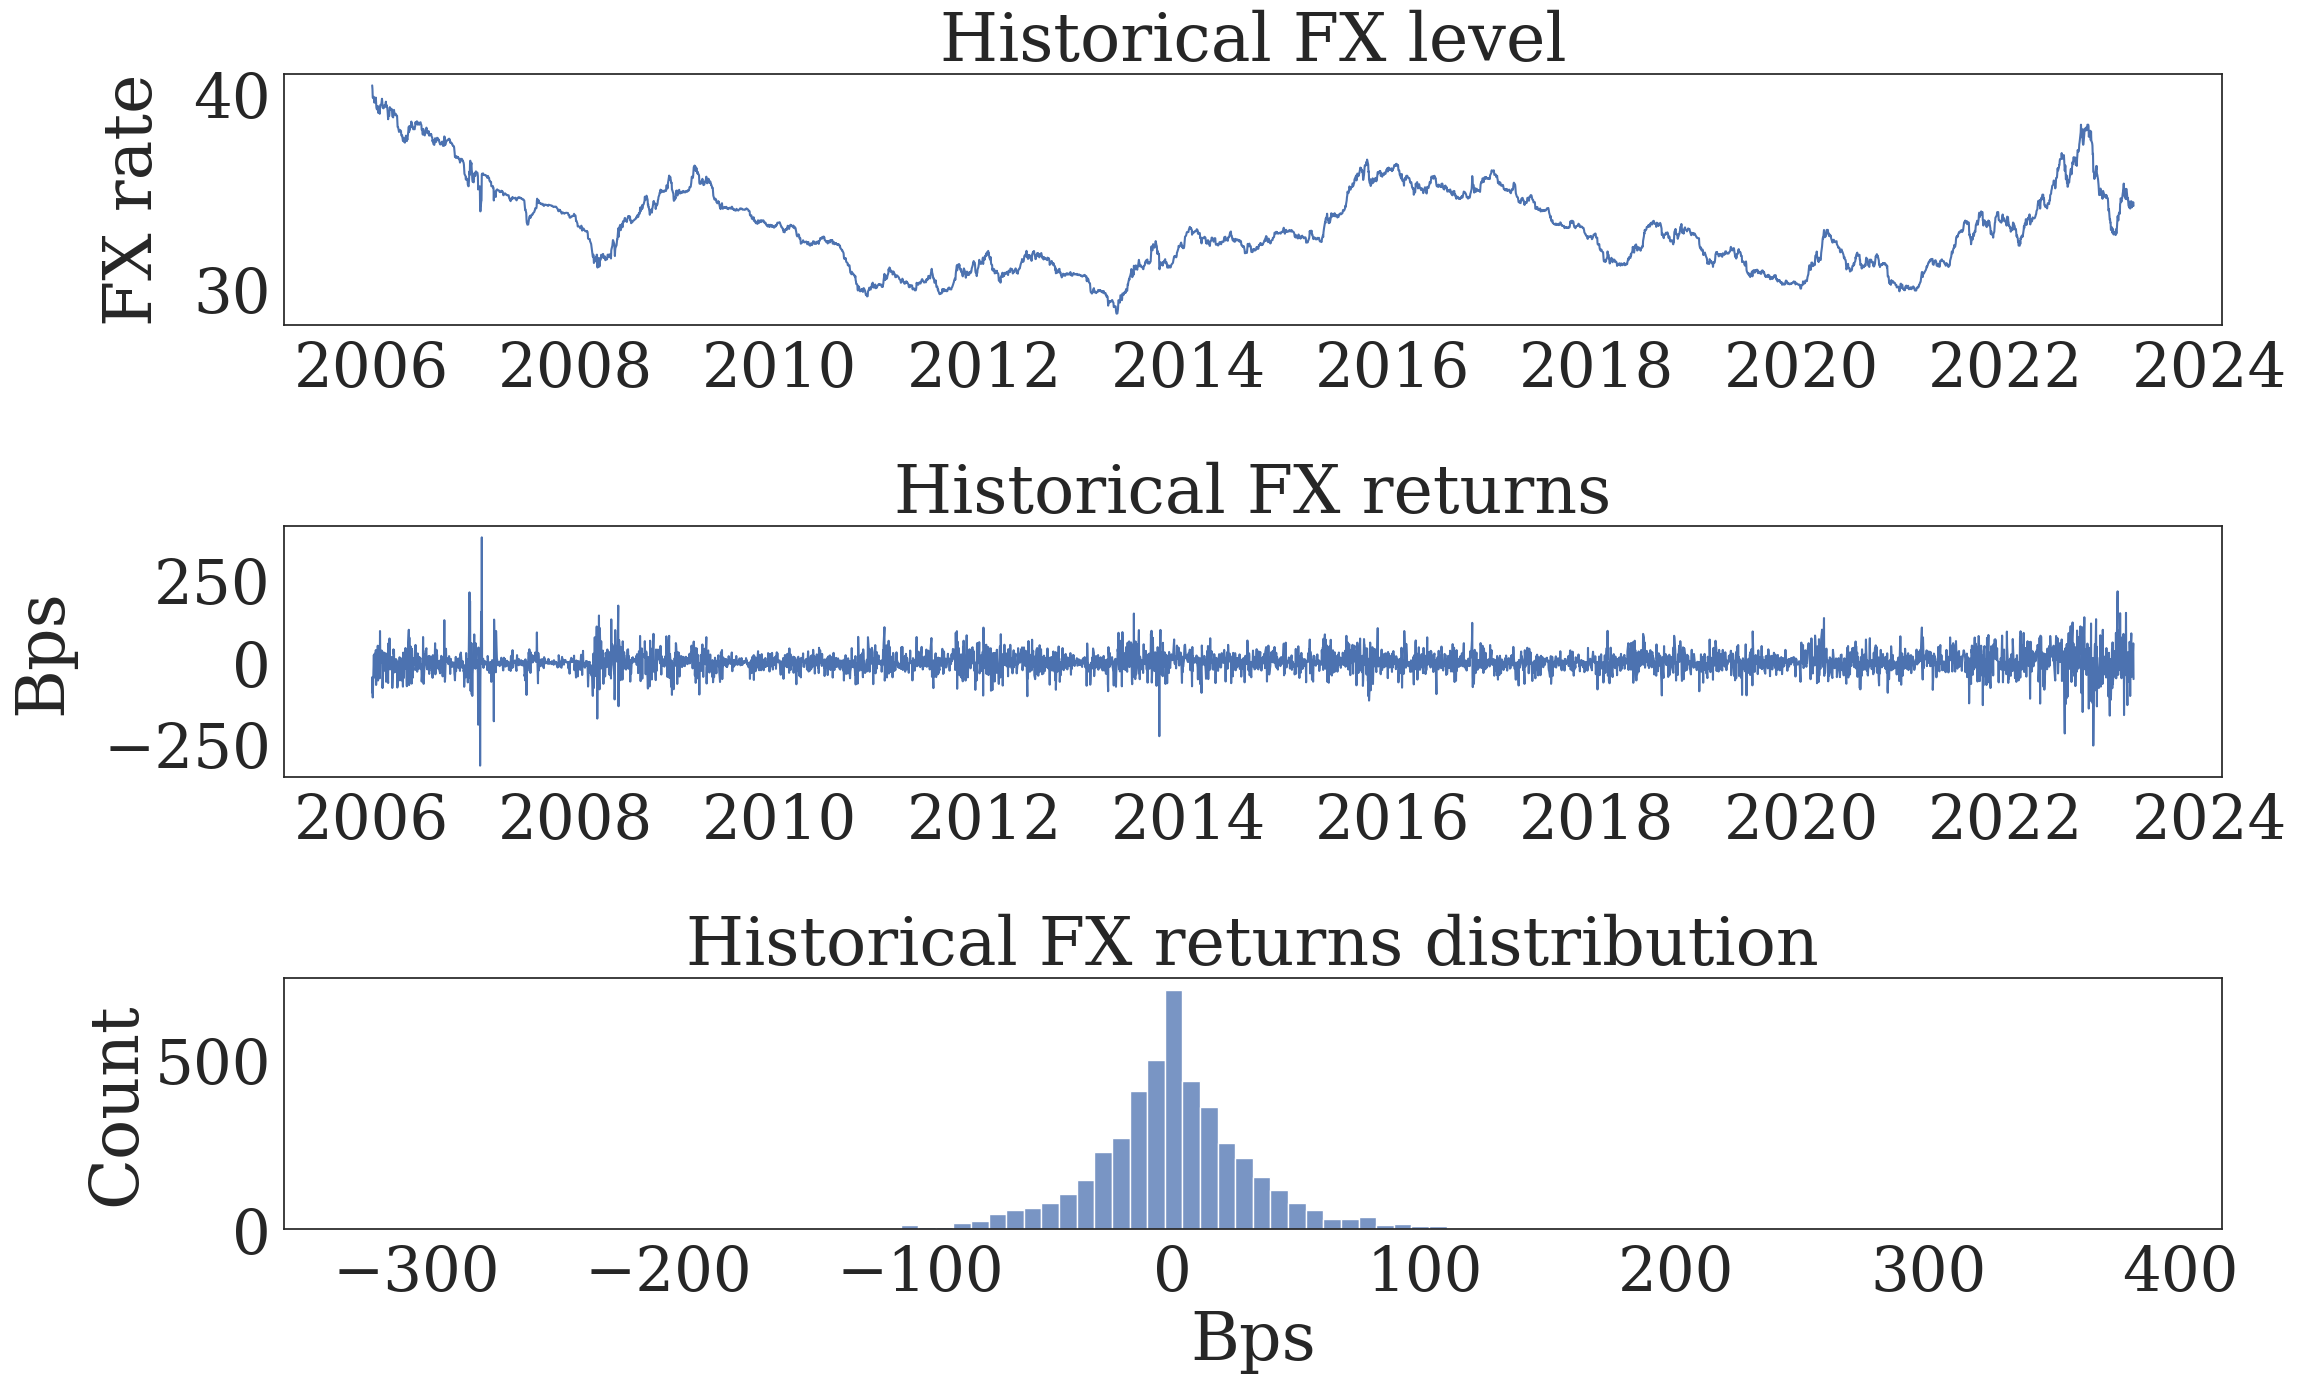

In [14]:
# Plot
dg.plot.plot_description(title_level='Historical FX level',
                    title_returns='Historical FX returns',
                    title_density='Historical FX returns distribution',
                    y_label_returns='Bps')
plt.subplots_adjust(hspace=0.8)

# Save the figure
desc_f = os.path.join(output_folder, 'descriptive_plot.pdf')
plt.savefig(desc_f, bbox_inches='tight')
plt.show()
plt.close('all')

### Fit the Model

In [15]:
# Fit the model
dgf = dg.fit()

                        AR-X - GJR-GARCH Model Results                        
Dep. Variable:         FX log returns   R-squared:                       0.029
Mean Model:                      AR-X   Adj. R-squared:                  0.028
Vol Model:                  GJR-GARCH   Log-Likelihood:               -21625.7
Distribution:                  Normal   AIC:                           43275.3
Method:            Maximum Likelihood   BIC:                           43352.3
                                        No. Observations:                 4497
Date:                Wed, Apr 19 2023   Df Residuals:                     4489
Time:                        08:46:36   Df Model:                            8
                                          Mean Model                                          
                                 coef    std err          t      P>|t|        95.0% Conf. Int.
----------------------------------------------------------------------------------------------
Cons

### Figure 2. Conditional FX Volatility Over Time

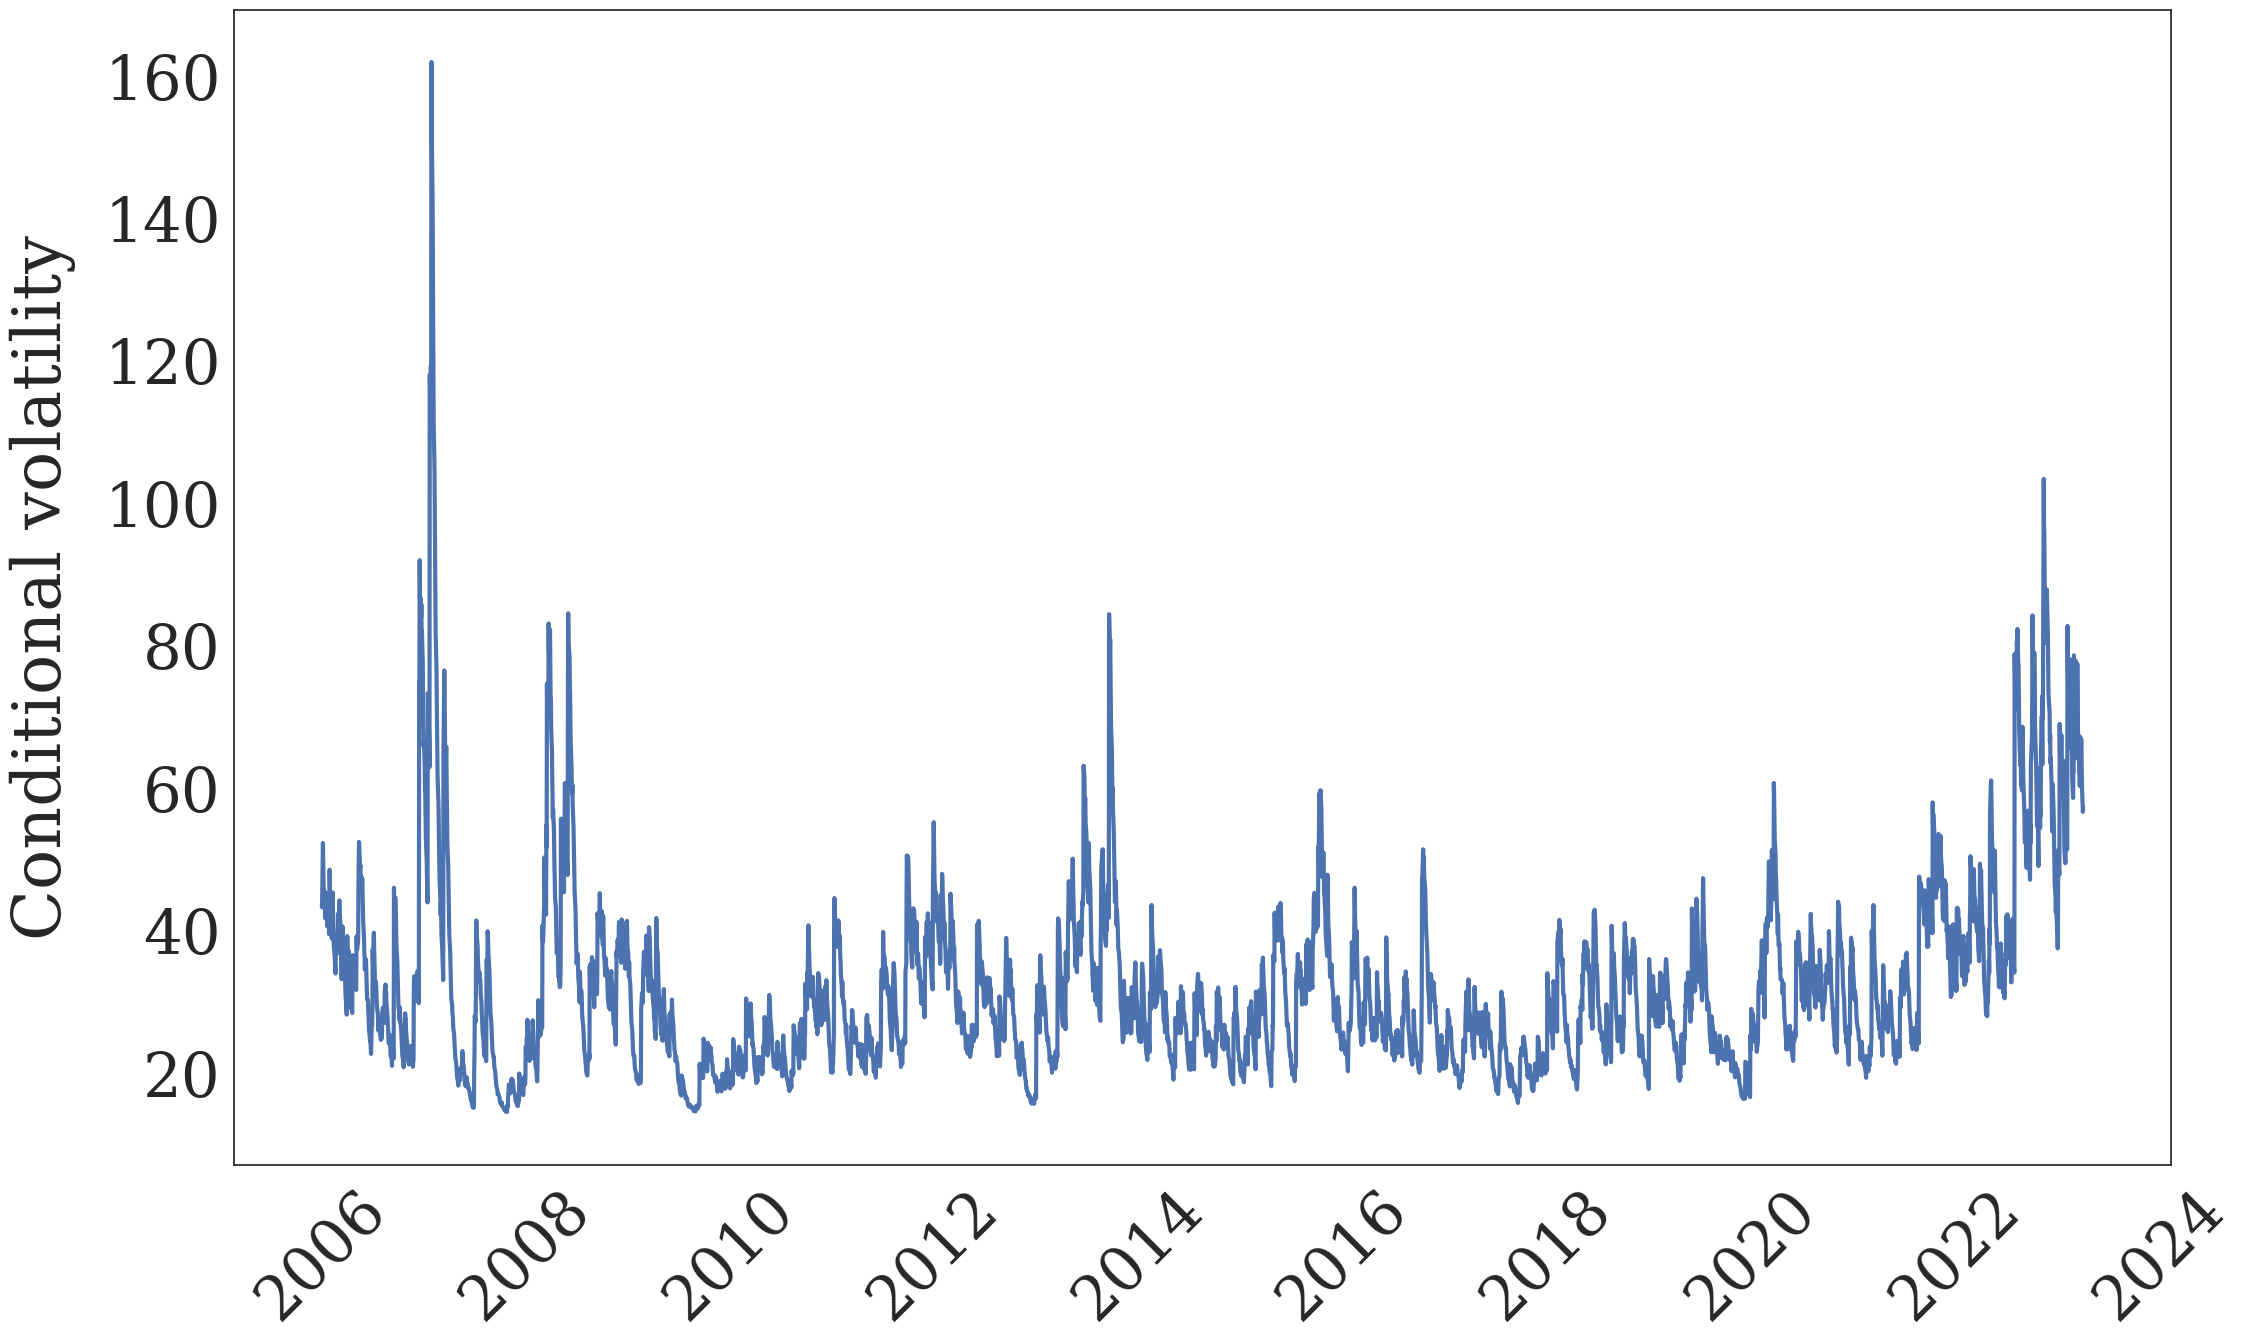

In [16]:
# Plot
dgf.plot.plot_in_cond_vol(start_date=None,
                     title='')
# Save the figure
cv_f = os.path.join(output_folder, 'conditional_vol_plot.pdf')
plt.savefig(cv_f, bbox_inches='tight')
plt.show()
plt.close('all')

## Step 3. Forecast the model

In [17]:
# Forecast 2023
dgfor = dgf.forecast(s_date, horizon=1)

### Figure 4. Out-of-sample Conditional Density (Joyplot) [This takes a long time]

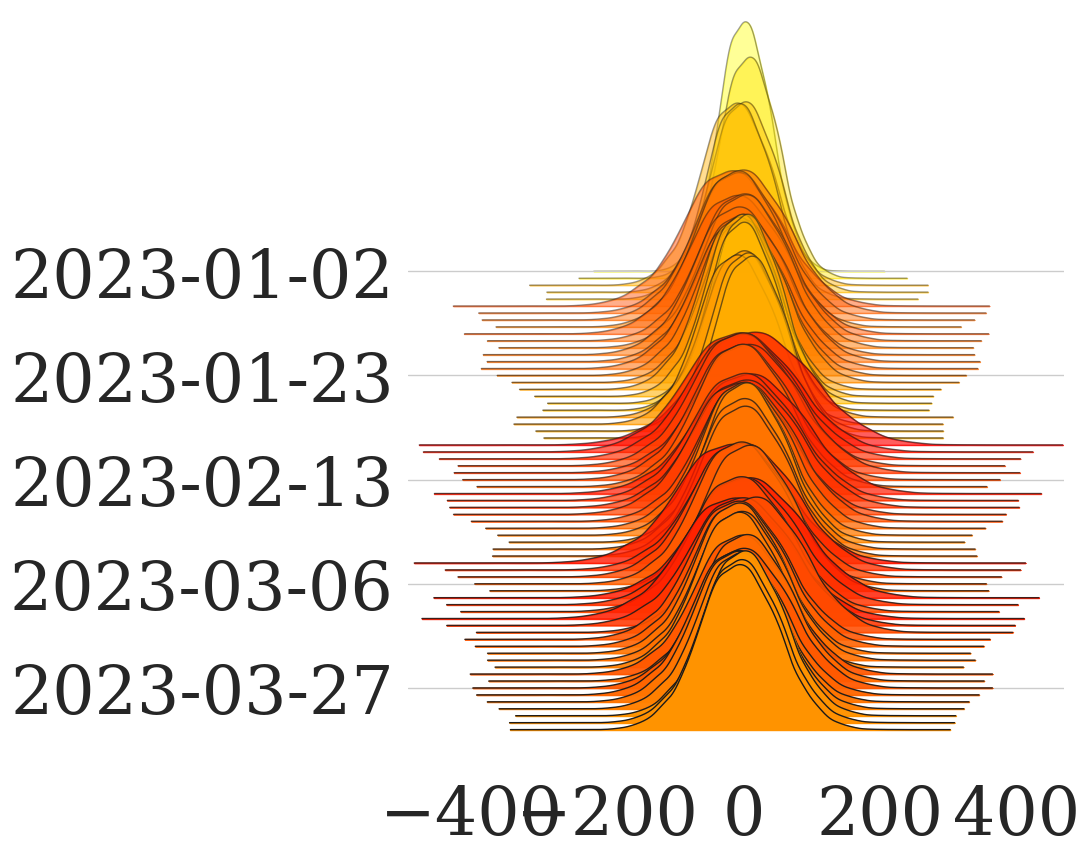

In [18]:
# Plot
dgfor.plot.plot_joyplot_out(
    title='',
    xlabel='',
    label_drop=15,
    xlimits_t=(-1000, 1000))

# Save the figure
joyplot_f = os.path.join(output_folder, 'joyplot.pdf')
plt.savefig(joyplot_f)
plt.show()
plt.close('all')


### Figure 5. Out-of-Sample Fan Chart

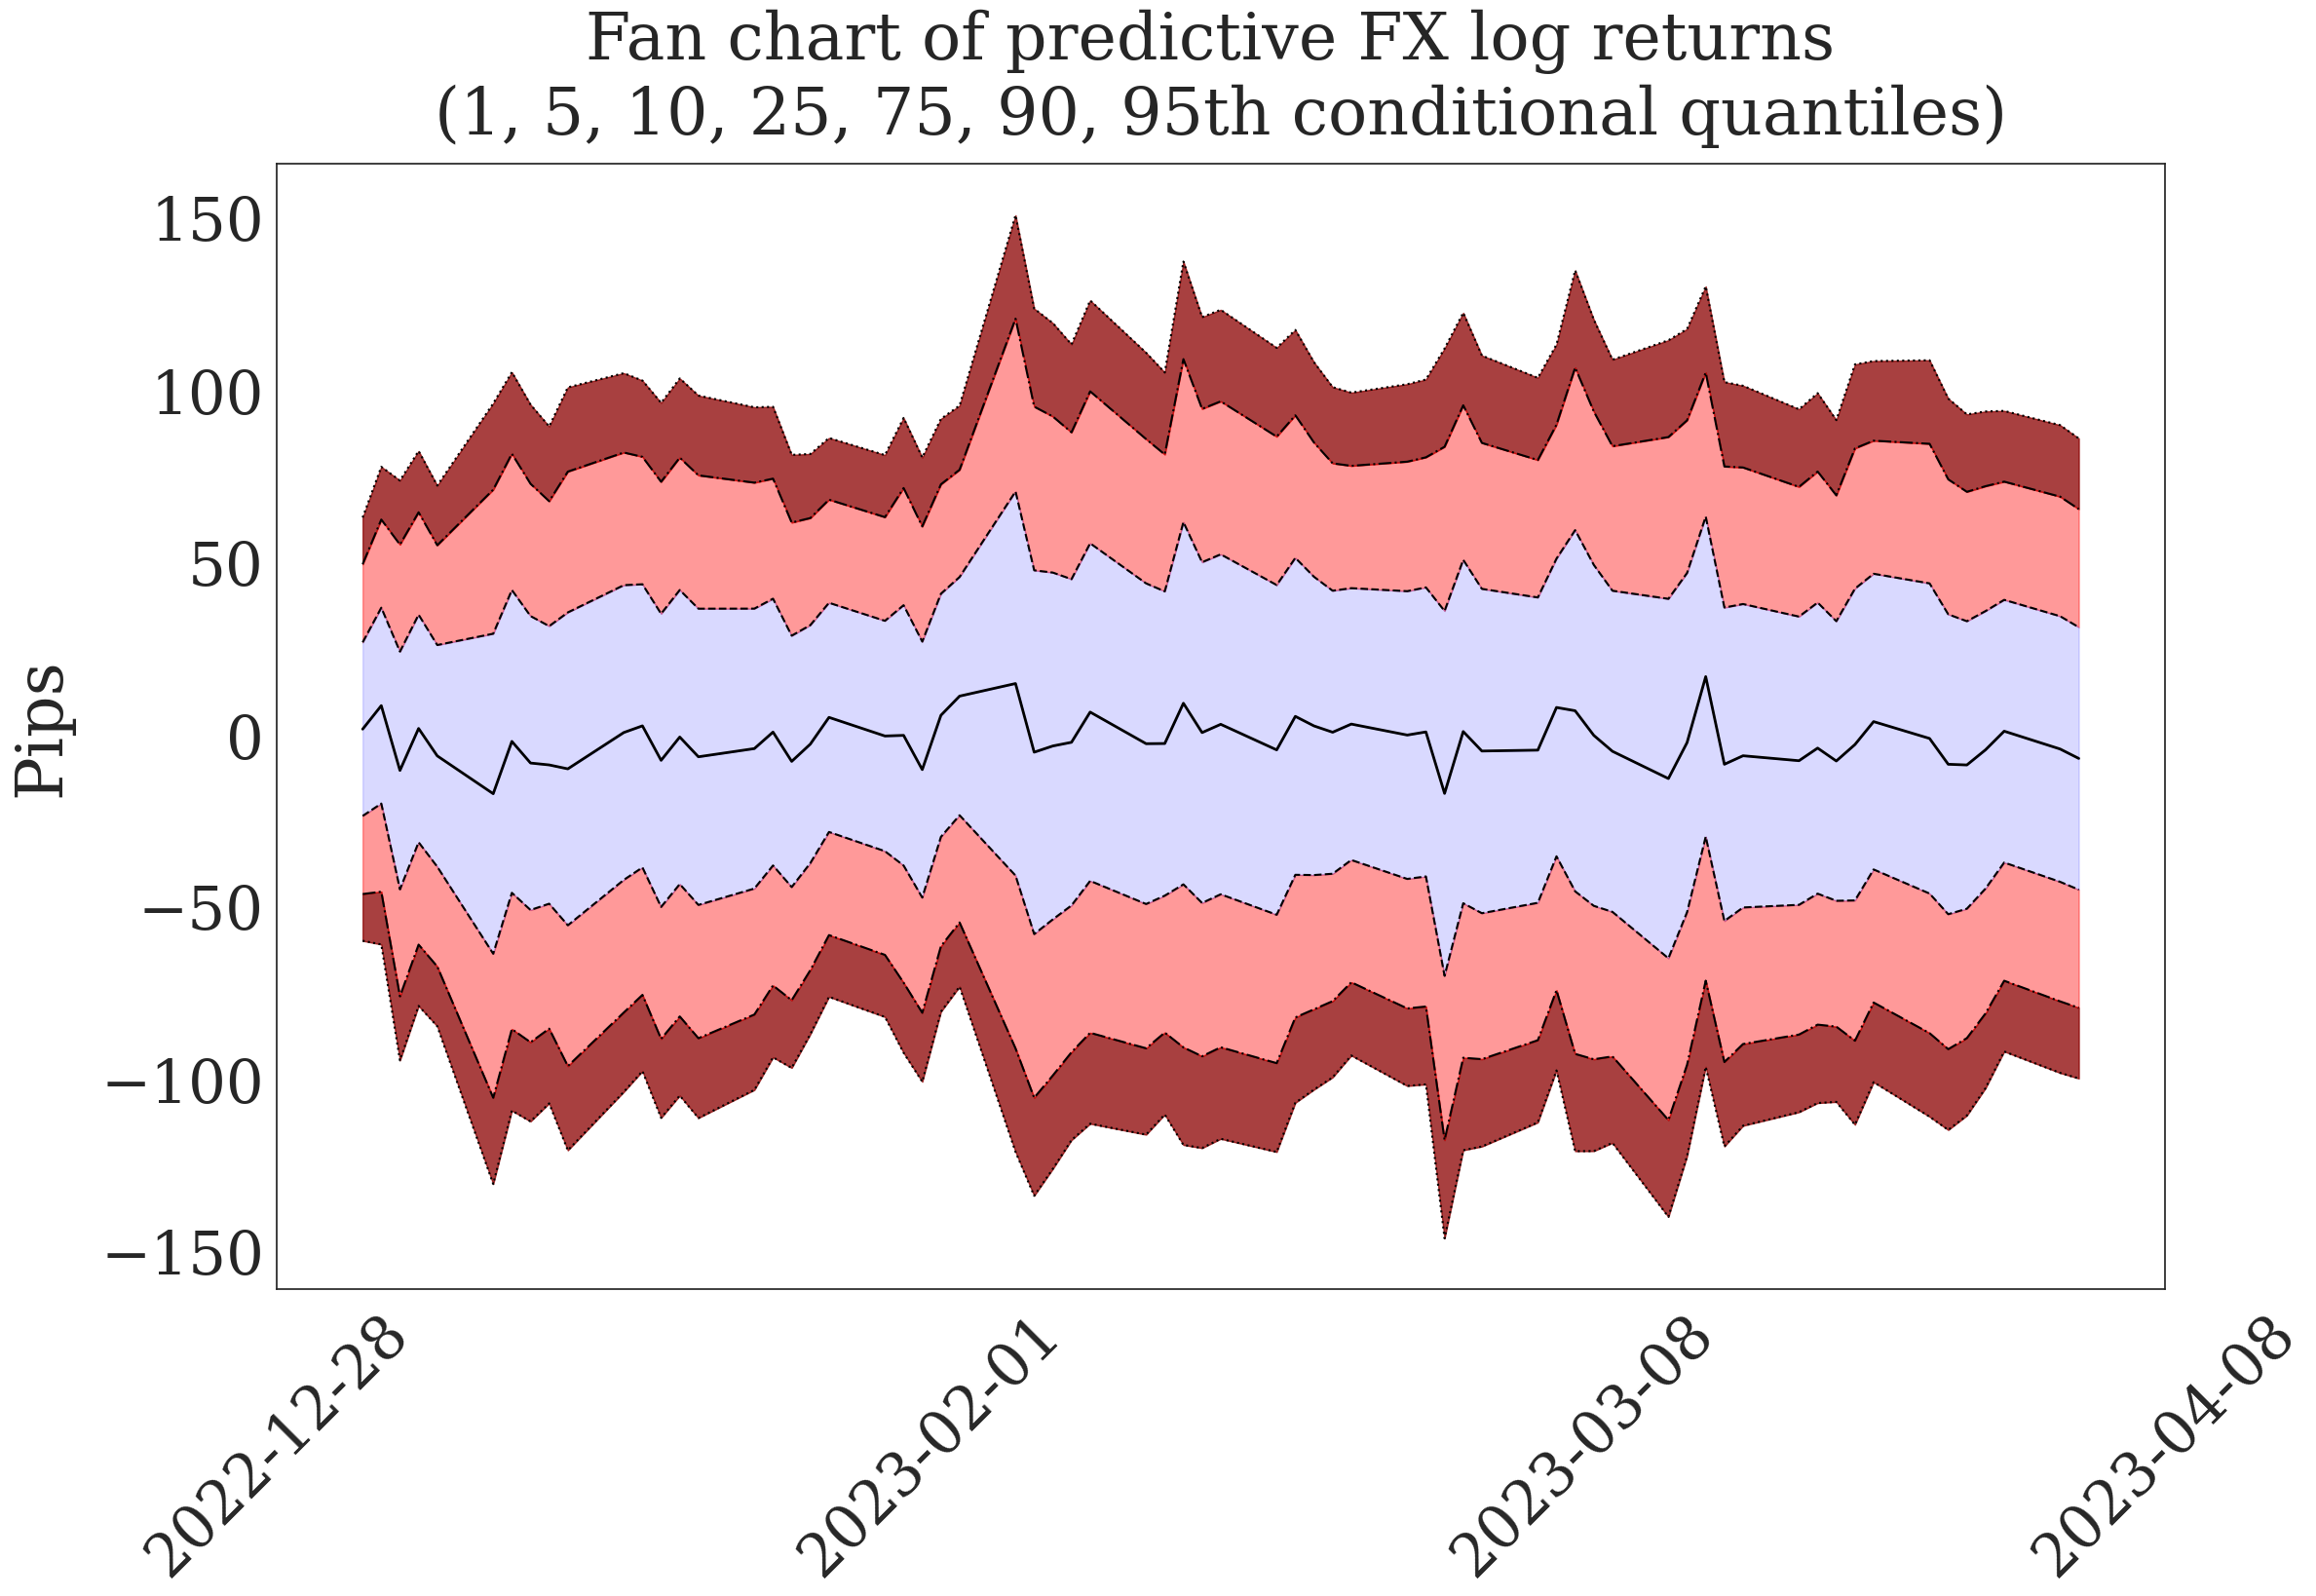

In [19]:
# Plot
dgfor.plot.plot_fan_chart(xticks_freq=35, title='Fan chart of predictive FX log returns \n'
                     '(1, 5, 10, 25, 75, 90, 95th conditional quantiles)')
plt.ylabel('Pips')

# Save the figure
fanchart_f = os.path.join(output_folder, 'fanchart.pdf')
plt.savefig(fanchart_f, bbox_inches='tight')
plt.show()
plt.close('all')

### Figure 6. Probability Integral Transform Test

<function matplotlib.pyplot.show(close=None, block=None)>

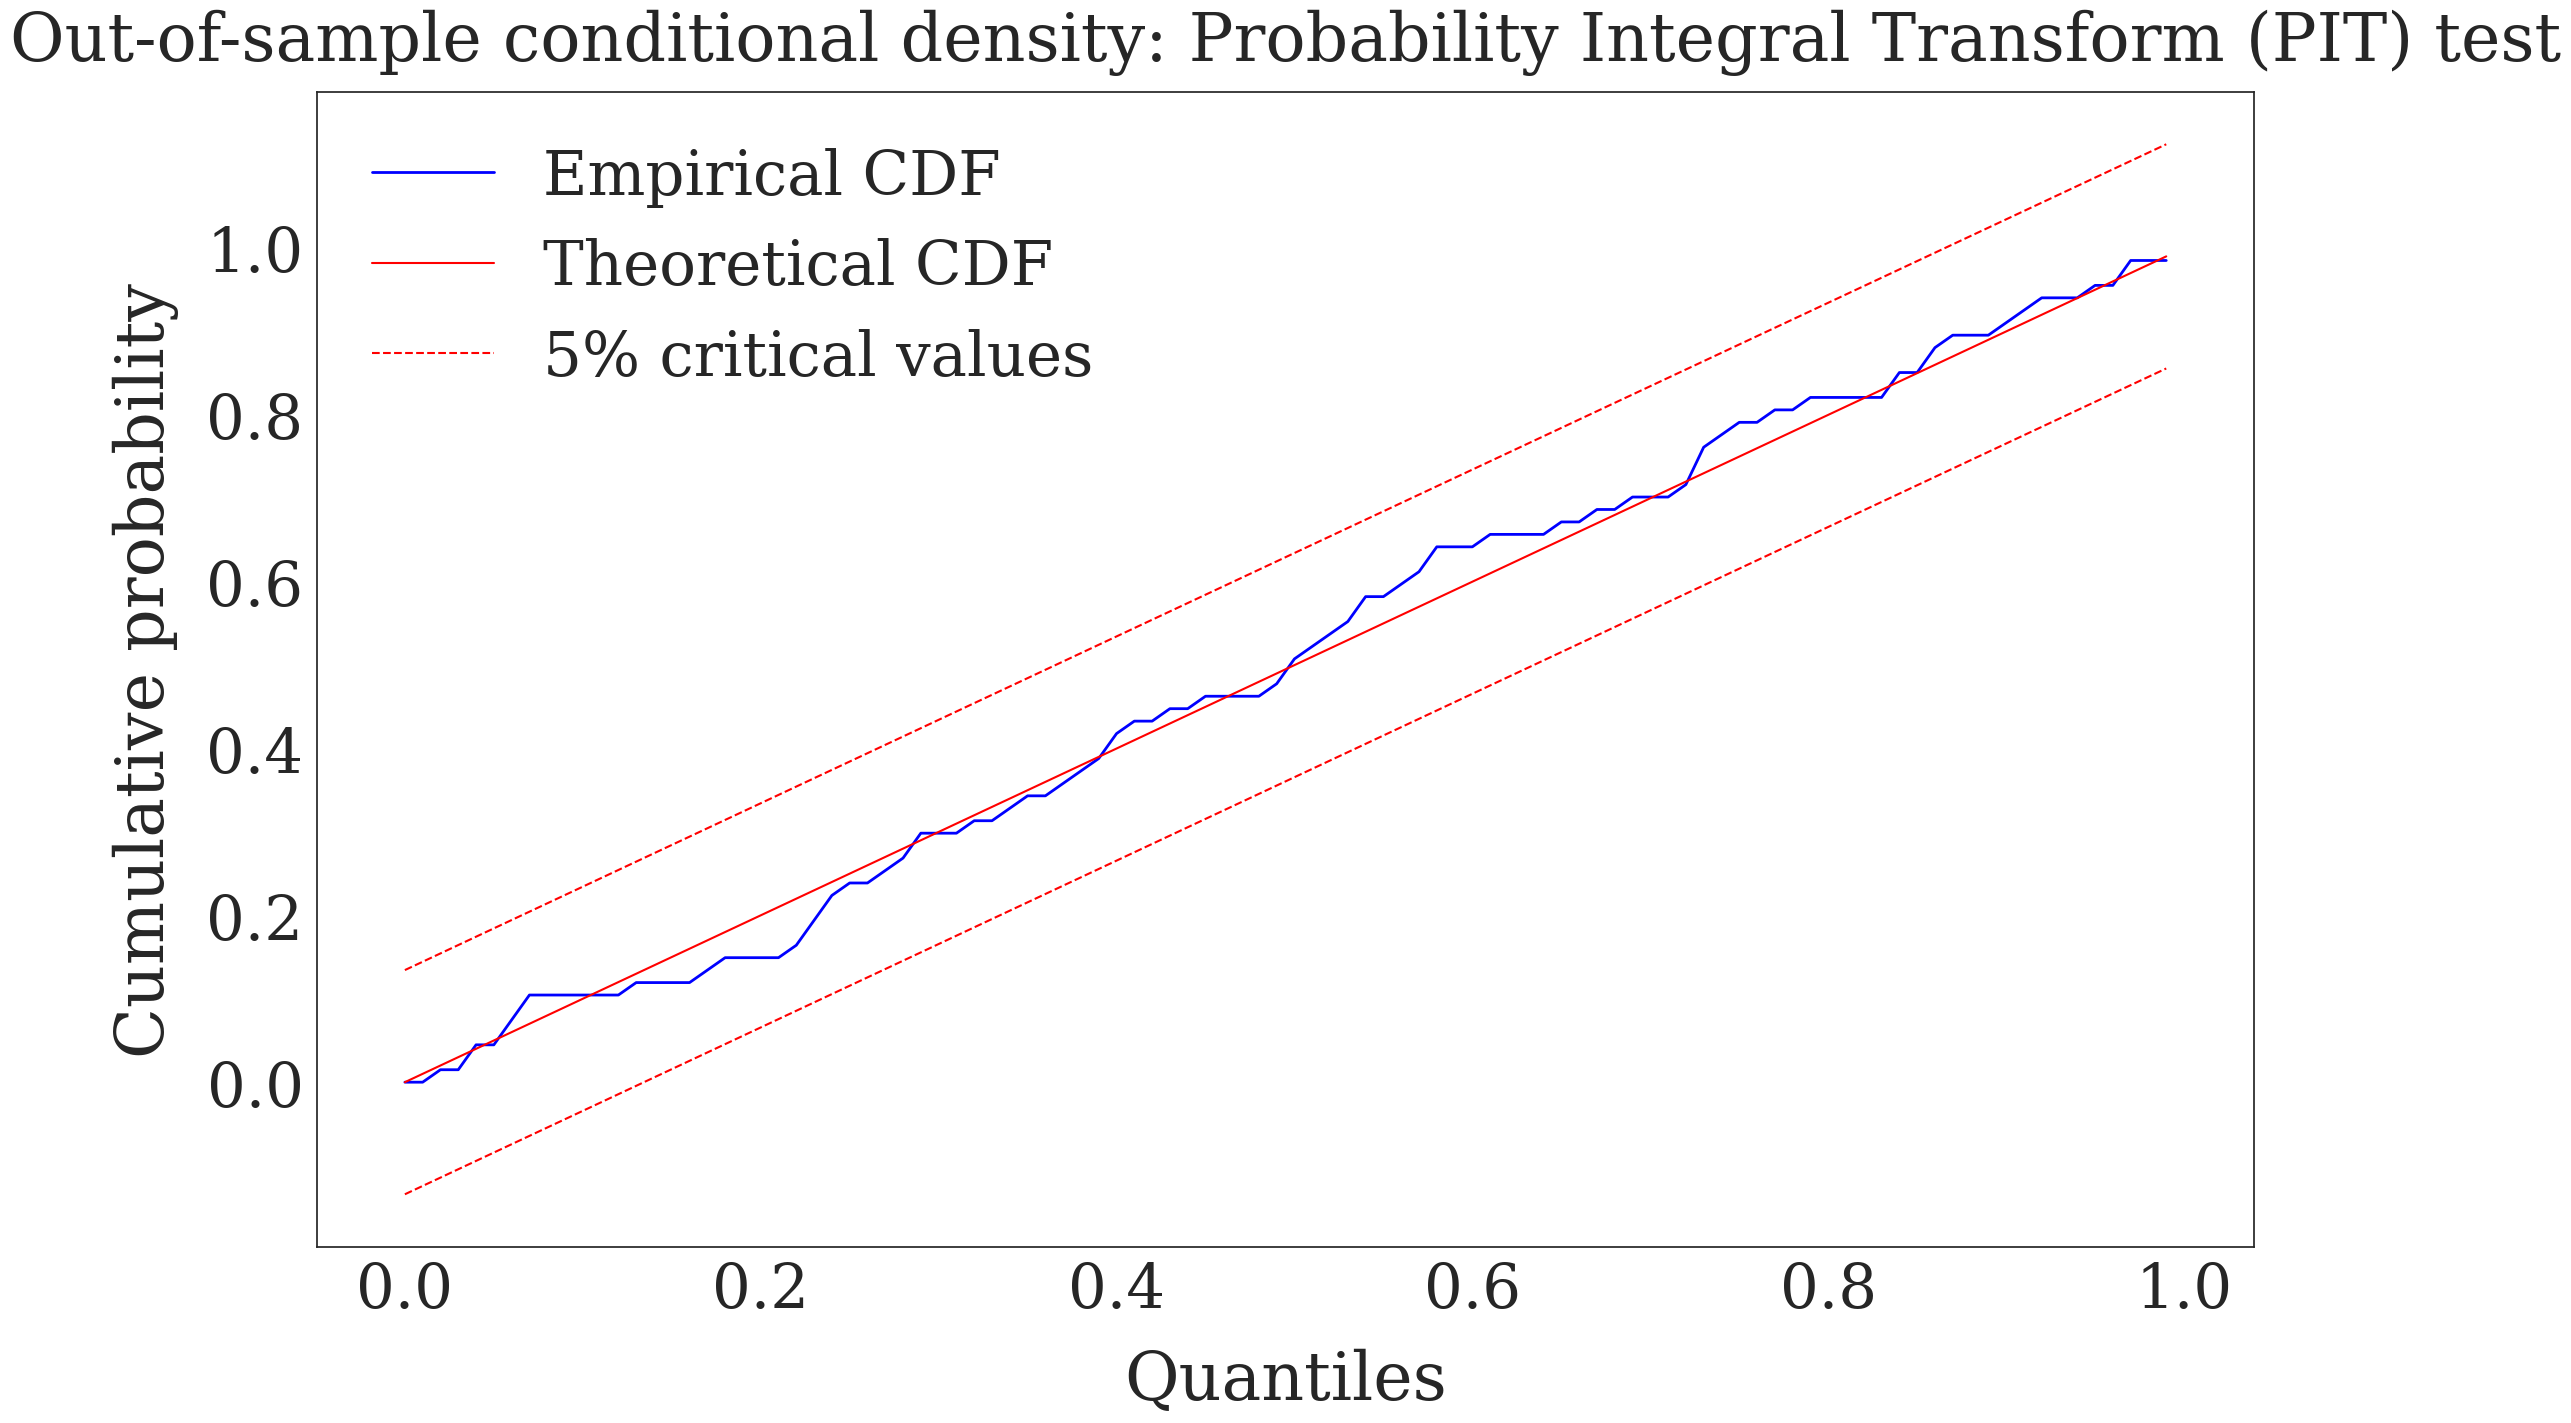

In [20]:
# Plot
dgfor.plot.plot_pit()
# Save the figure
pitchart_f = os.path.join(output_folder, 'pitchart.pdf')
plt.savefig(pitchart_f, bbox_inches='tight')
plt.show 

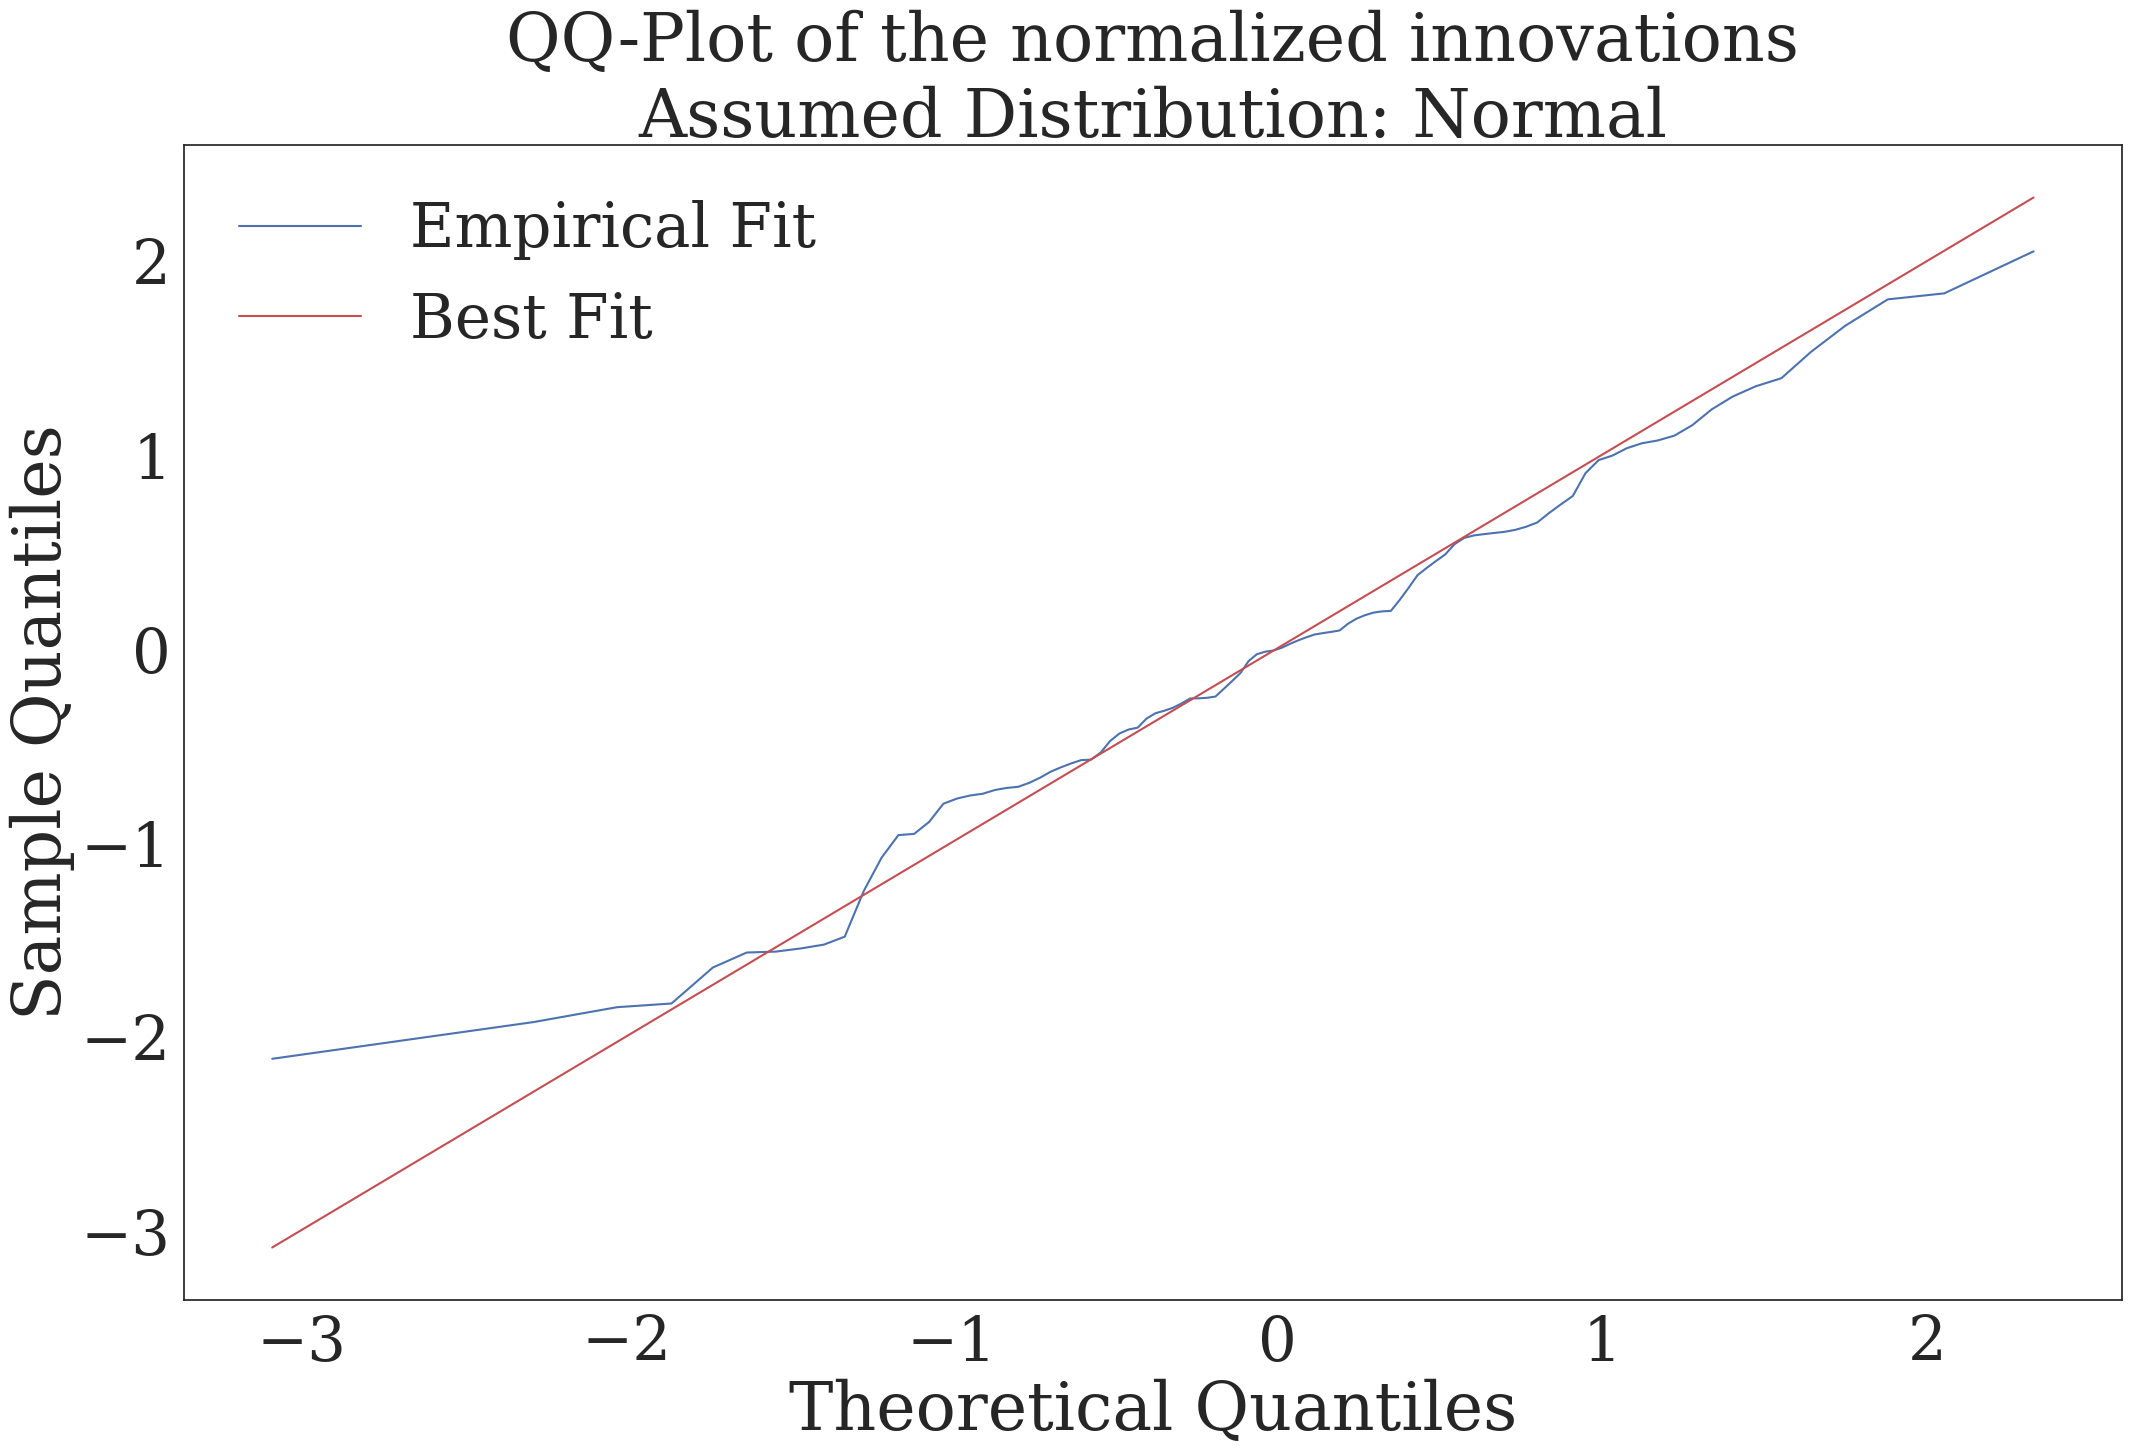

In [21]:
dgfor.plot.plot_qqplot_normalized_innovations()
# Save the figure
qqchart_f = os.path.join(output_folder, 'qqplot.pdf')
plt.savefig(pitchart_f, bbox_inches='tight')
plt.show()

### Figure 7. VaR FX Interventions Rule Based on a Given Information Set

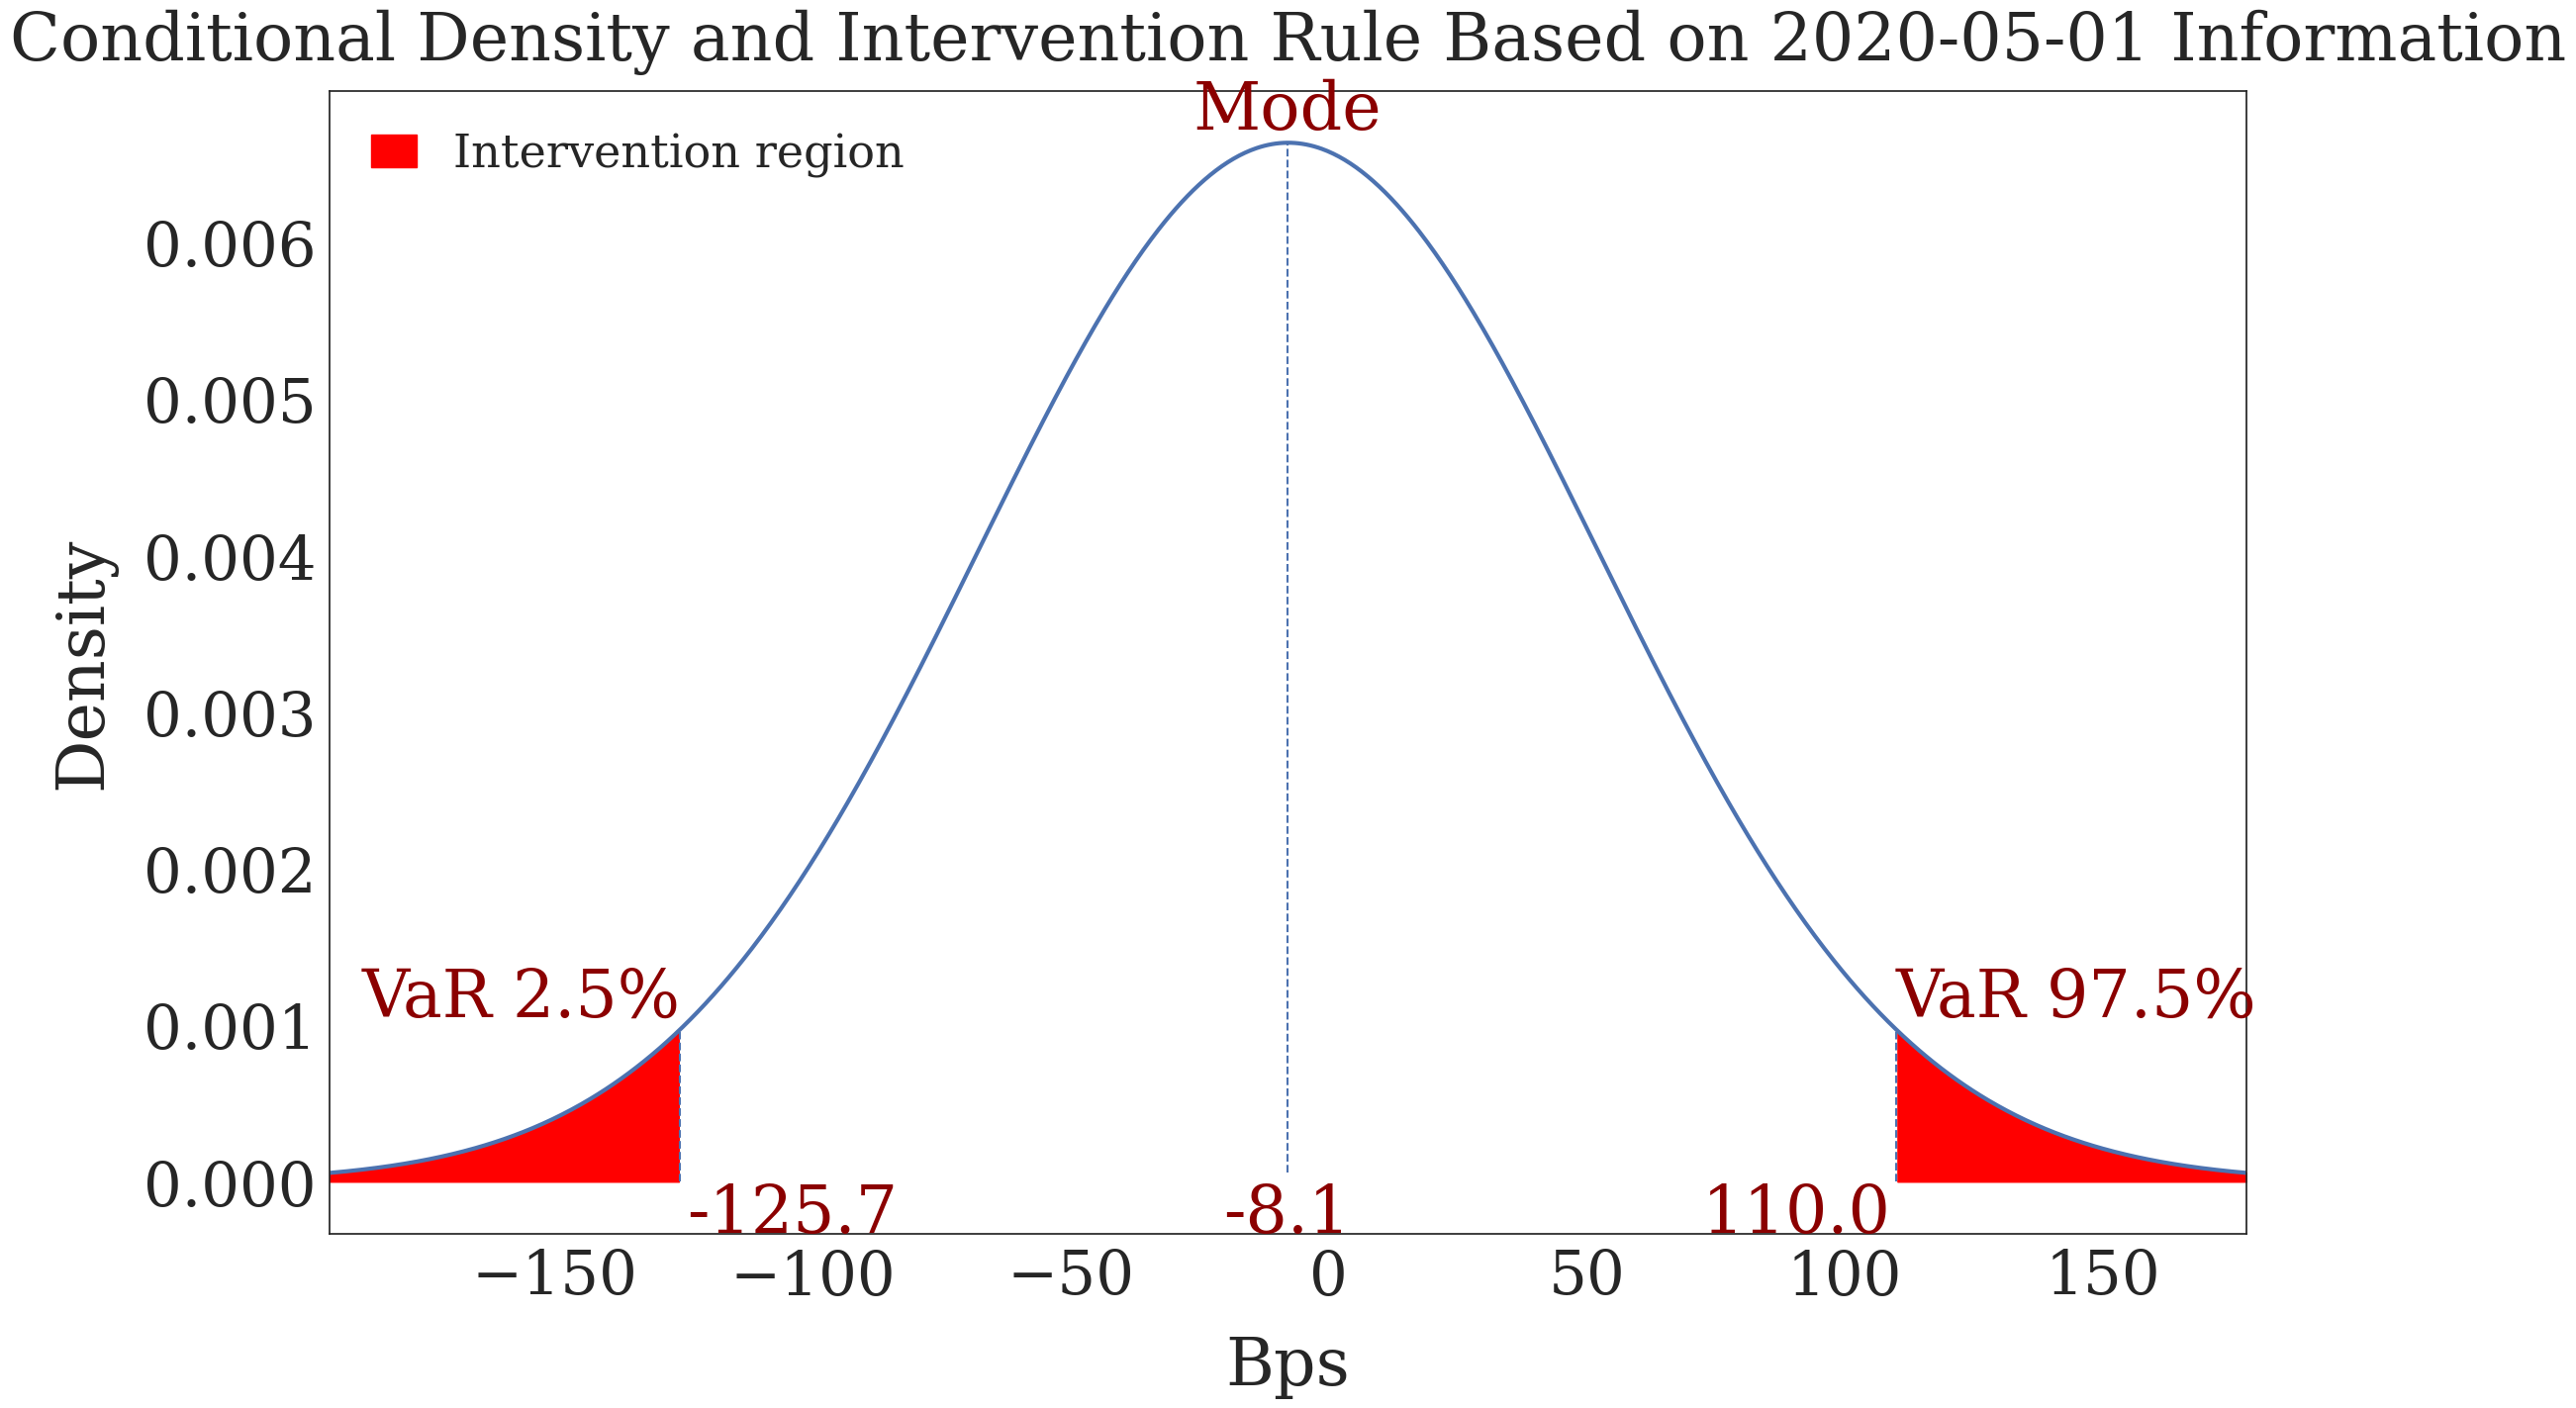

In [22]:
# Plot
dgfor.plot.plot_pdf_rule(fdate=f_date, q_low=0.025, q_high=0.975, 
                    title='Conditional Density and Intervention Rule Based on 2020-05-01 Information', 
                    ylabel='Density', xlabel='Bps')

# Save the figure
var_rule_f = os.path.join(output_folder, 'var_rule.pdf')
plt.savefig(var_rule_f, bbox_inches='tight')
plt.show()

### Figure 8. Conditional CDF, Out-of-sample

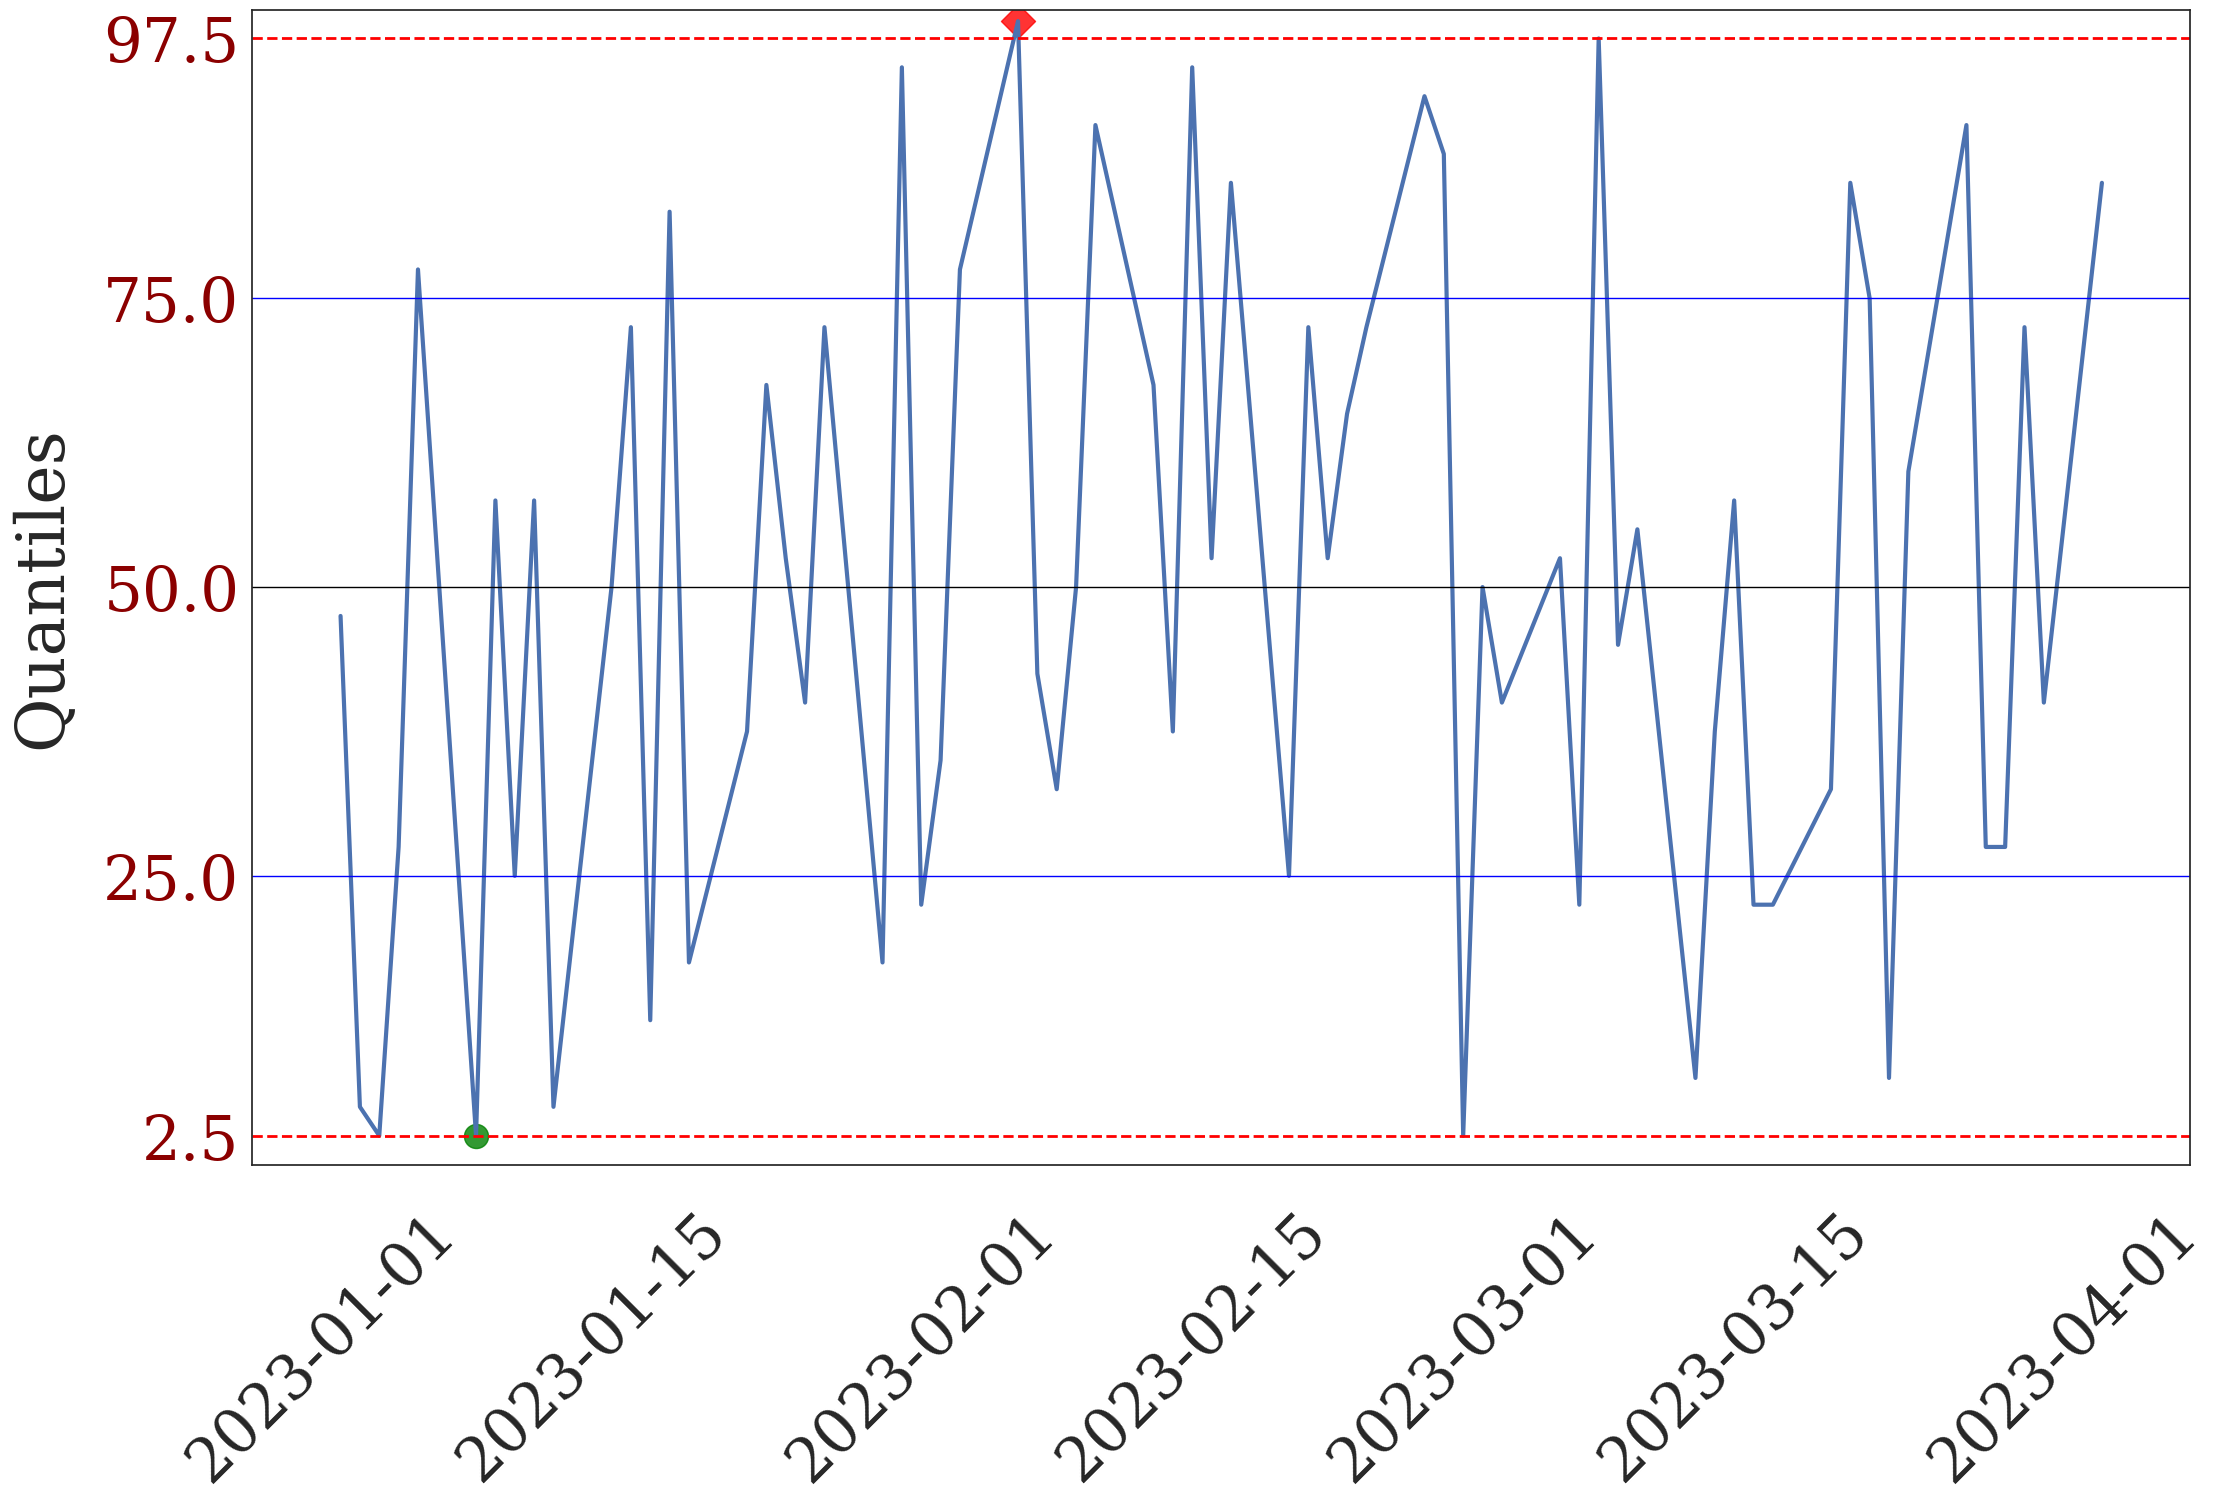

In [23]:
# Plot
dgfor.plot.plot_conditional_cdf(q_low=low_th, q_high=high_th, size=300, title='', ylabel='Quantiles')

# Save the figure
cond_cdf_f = os.path.join(output_folder, 'conditional_cdf.pdf')
plt.savefig(cond_cdf_f, bbox_inches='tight')
plt.show()

### Figure 9. Conditional VaR Exceedance, Out-of-Sample

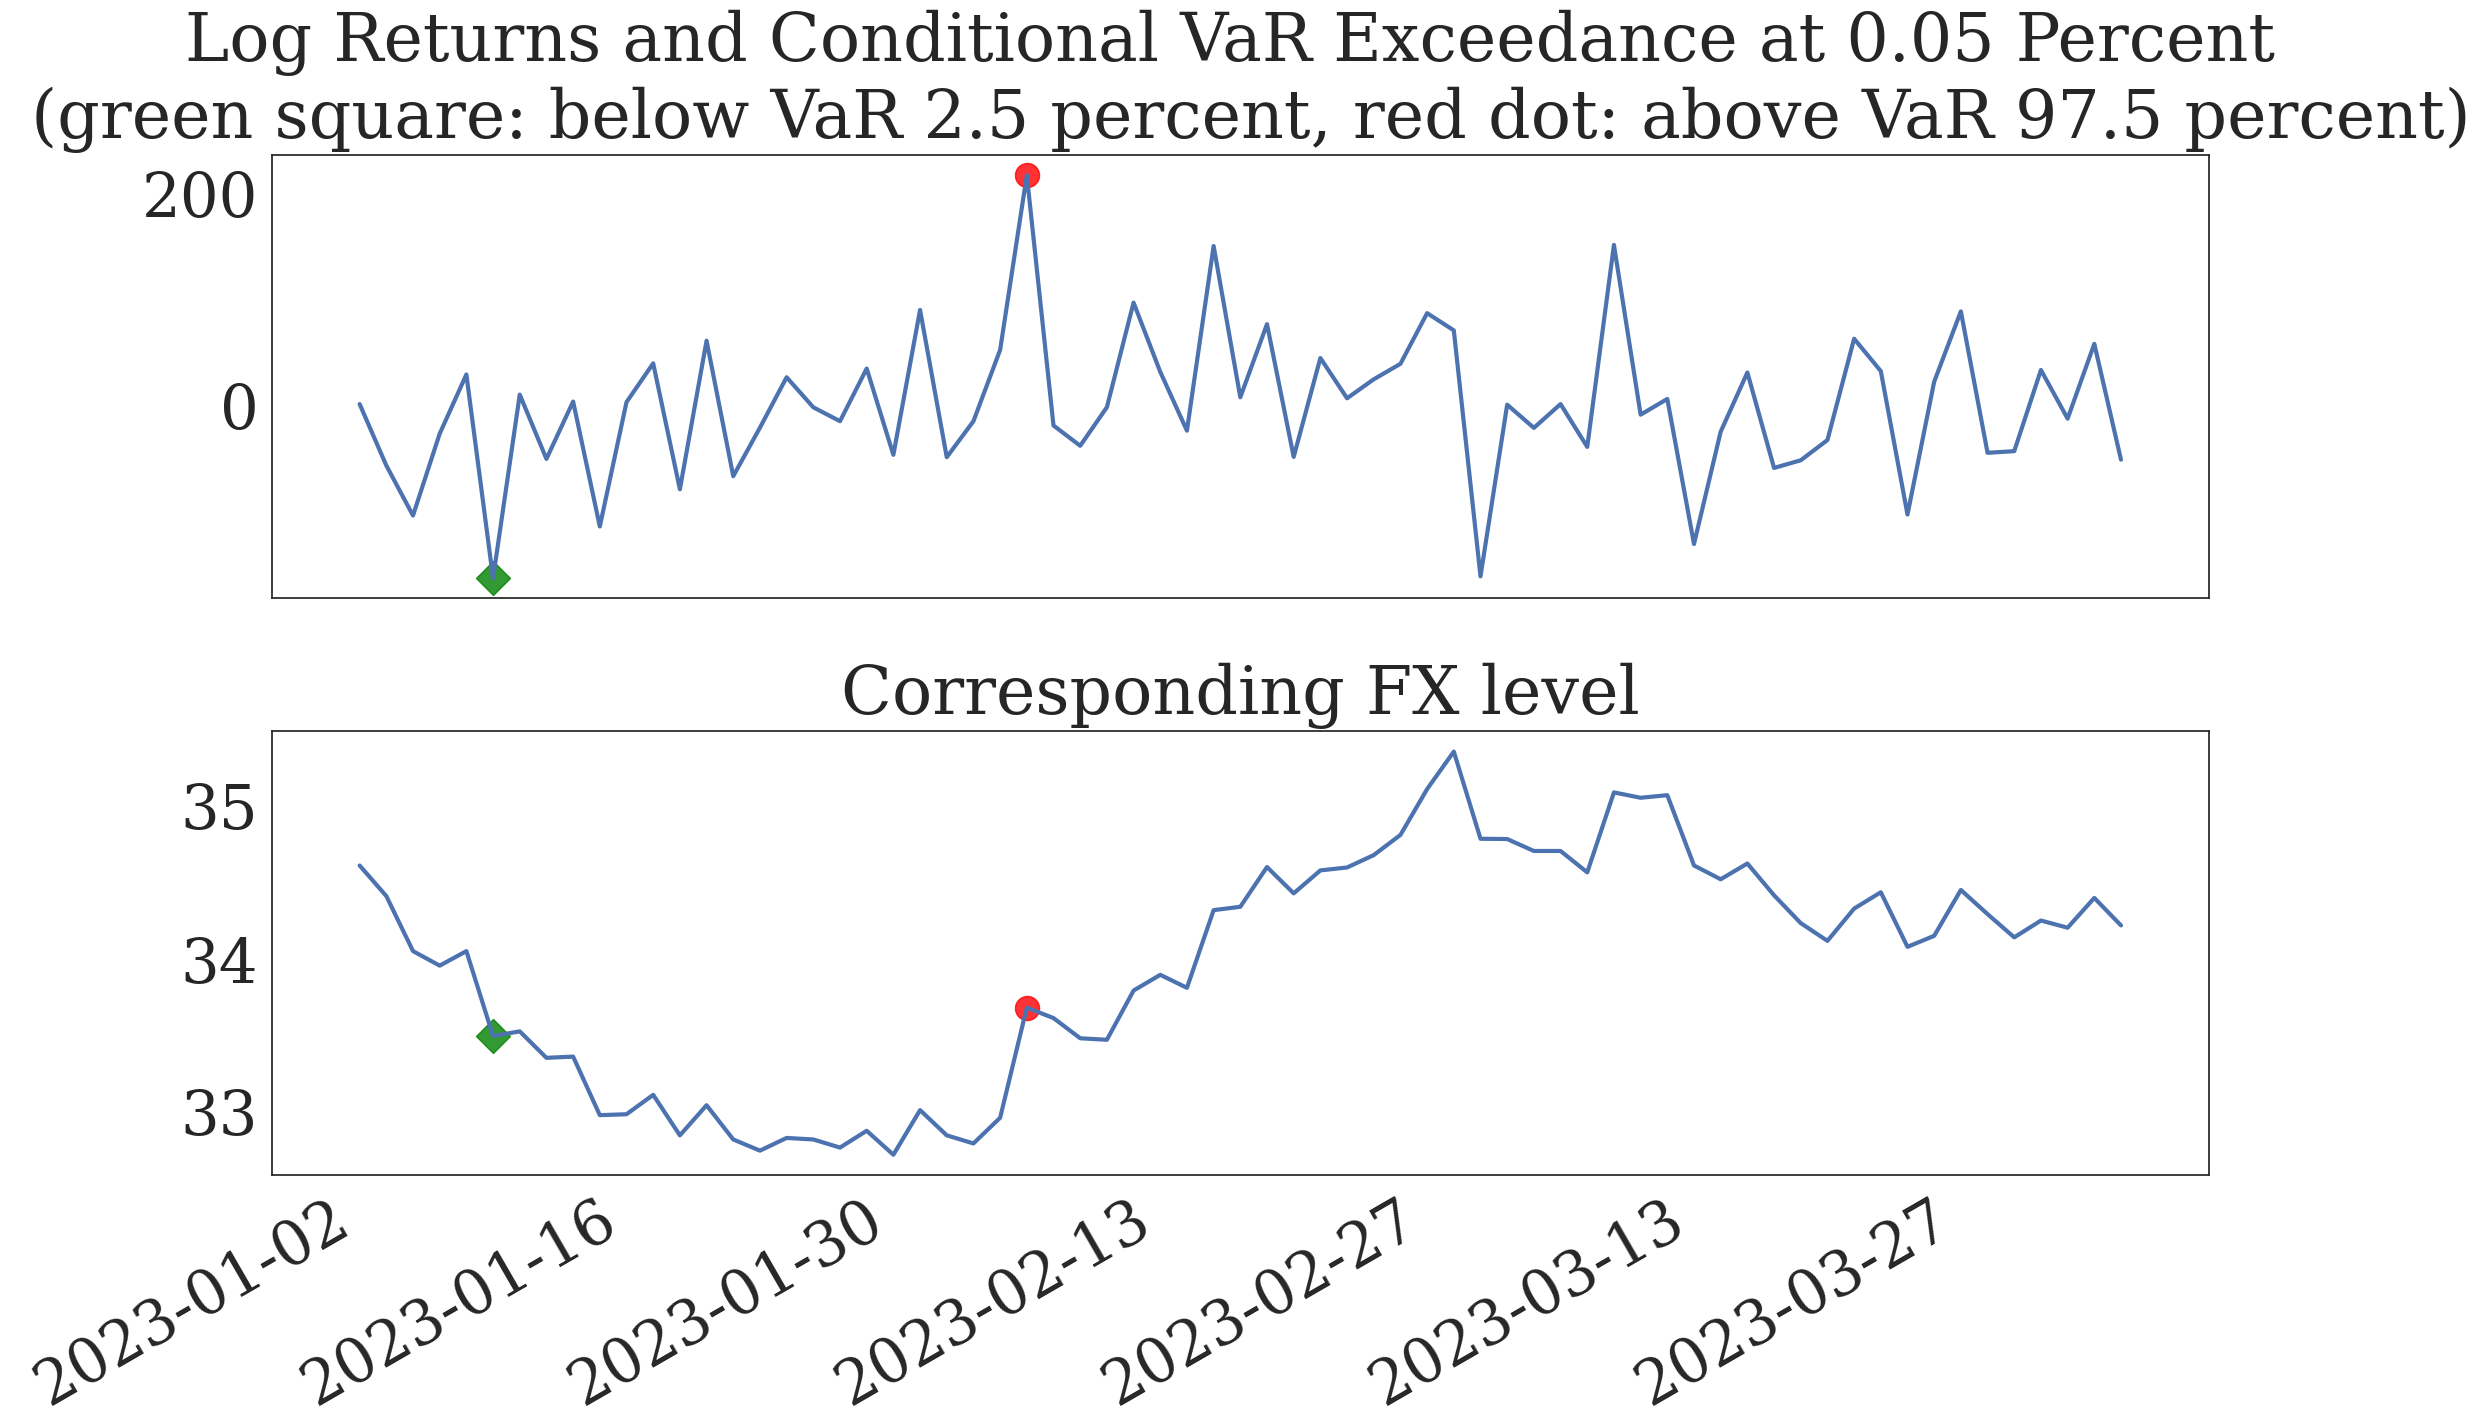

In [24]:
# Plot
dgfor.plot.plot_var_exceedance(qv_l=[low_th, high_th], 
                          title_1= (f'Log Returns and Conditional VaR Exceedance at {low_th*2} Percent'
                        f' \n (green square: below VaR {low_th*100} percent, red dot: above VaR {high_th*100} percent)'),
                          title_2='Corresponding FX level',
                          swap_color=True, size=300)

# Save the figure
cond_exc_f = os.path.join(output_folder, 'conditional_exceedance.pdf')
plt.savefig(cond_exc_f, bbox_inches='tight')
plt.show()

## Step 3. Optimize the Model

In [56]:
dgo = dg.optimize()

In [57]:
mean_optim = dgo.optimize_mean()

Optimizing the Mean model. step 1: exog_l


100%|██████████| 63/63 [00:04<00:00, 13.36it/s]


Best Out-Of-Sample combination of exogenous variables: 
Interbank rate first diff,EURUSD log returns,VIX first diff,Oil prices log returns
Optimizing the Mean model. step 2: number of lags


100%|██████████| 10/10 [00:00<00:00, 12.58it/s]


Best Out-Of-Sample number of lags: 1


In [58]:
vol_dist_optimization = dgo.optimize_vol_distrib()
print(vol_dist_optimization)
vol_dist_p = os.path.join(output_folder, 'vol_dist_opt_table.csv')
vol_optim = vol_dist_optimization.to_csv(vol_dist_p)

100%|██████████| 28/28 [02:36<00:00,  5.58s/it]

Best Out-Of-Sample Volatility Model: RiskMetric
Best Out-Of-Sample Distribution Family: StudentT
                                  KS_normalized_innovations  \
volatility_model distribution                                 
Constant         Normal                               False   
ARCH             Normal                               False   
EGARCH           Normal                               False   
GARCH            Normal                               False   
GJR-GARCH        Normal                               False   
RiskMetric       Normal                               False   
EWMA             Normal                               False   
GJR-GARCH        SkewStudent                          False   
GARCH            SkewStudent                          False   
GJR-GARCH        StudentT                             False   
GARCH            StudentT                             False   
EGARCH           SkewStudent                          False   
                 Stud

In [59]:
params_finetuning = dgo.fine_tune_model()

Fine Tune the best model
exog_l = ['Interbank rate first diff', 'EURUSD log returns', 'VIX first diff', 'Oil prices log returns']
lags = 1
volatility model = RiskMetric
distribution family = StudentT
Stabilize Parameters with ZigZag method ...
Converged !


In [31]:
best_combination = dgo.best_combination
best_lag = dgo.best_lag
best_vol_mod_name = dgo.best_vol_mod_name
best_distrib_name = dgo.best_distrib_name
best_vol_mod = dgo.best_vol_mod
best_distrib = dgo.best_distrib

In [55]:
from varfxi import distGARCH as ds
import imp; imp.reload(ds)
# Customizable:
dg = ds.DistGARCH(depvar_str='FX log returns',
               data=df,
               level_str='FX level', 
               exog_l=baseline, 
               lags_l=[1]
)
dgo = dg.optimize()
dgo.best_combination = best_combination 
dgo.best_lag = best_lag 
dgo.best_vol_mod_name = best_vol_mod_name 
dgo.best_vol_mod= best_vol_mod
dgo.best_distrib_name = best_distrib_name
dgo.best_distrib = best_distrib

In [52]:
params_finetuning = dgo.fine_tune_model()
params_finetuning

Fine Tune the best model
exog_l = ['Interbank rate first diff', 'EURUSD log returns', 'VIX first diff', 'Oil prices log returns']
lags = 1
volatility model = RiskMetric
distribution family = StudentT
Stabilize Parameters with ZigZag method ...
0
1
2
3
Converged !


iteration_0               iteration_1                \
                               params       pvalues      params       pvalues   
Const                       -0.402106  4.236208e-01   -1.067081  9.024445e-03   
Interbank rate first diff  -18.067507  1.126820e-01  -21.888893  3.046660e-02   
EURUSD log returns           0.095059  3.658096e-22    0.073474  1.204655e-19   
VIX first diff               0.479010  1.307056e-01    0.406690  1.415401e-01   
Oil prices log returns      -0.005542  5.119435e-03   -0.007548  4.438961e-05   
nu                           4.602797  1.806597e-91    4.592381  5.156783e-91   

                          iteration_2               iteration_3                
                               params       pvalues      params       pvalues  
Const                       -1.089015  7.679432e-03   -1.089682  7.641128e-03  
Interbank rate first diff  -22.079665  2.900493e-02  -22.118634  2.871313e-02  
EURUSD log returns           0.072797  2.543956e-19    0.072770  2.620393e-19  
VIX first diff               0.388191  1.609954e-01    0.387268  1.619664e-01  
Oil prices log returns      -0.007639  3.738522e-05   -0.007642  3.720984e-05  
nu                           4.592931  5.978964e-91    4.592929  5.997595e-91

Model is fixed and won't be fitted again. The parameter provided will be used
                         AR-X - RiskMetrics2006 Model Results                        
Dep. Variable:                FX log returns   R-squared:                          --
Mean Model:                             AR-X   Adj. R-squared:                     --
Vol Model:                   RiskMetrics2006   Log-Likelihood:               -21446.5
Distribution:       Standardized Student's t   AIC:                           42905.1
Method:            User-specified Parameters   BIC:                           42943.6
                                               No. Observations:                 4498
Date:                       Wed, Apr 19 2023                                         
Time:                               09:40:05                                         
              Mean Model             
                                 coef
-------------------------------------
Const                         -1.0

<Axes: title={'center': 'Conditional density and intervention rule based on 2023-04-04 information'}, xlabel='bps', ylabel='density'>

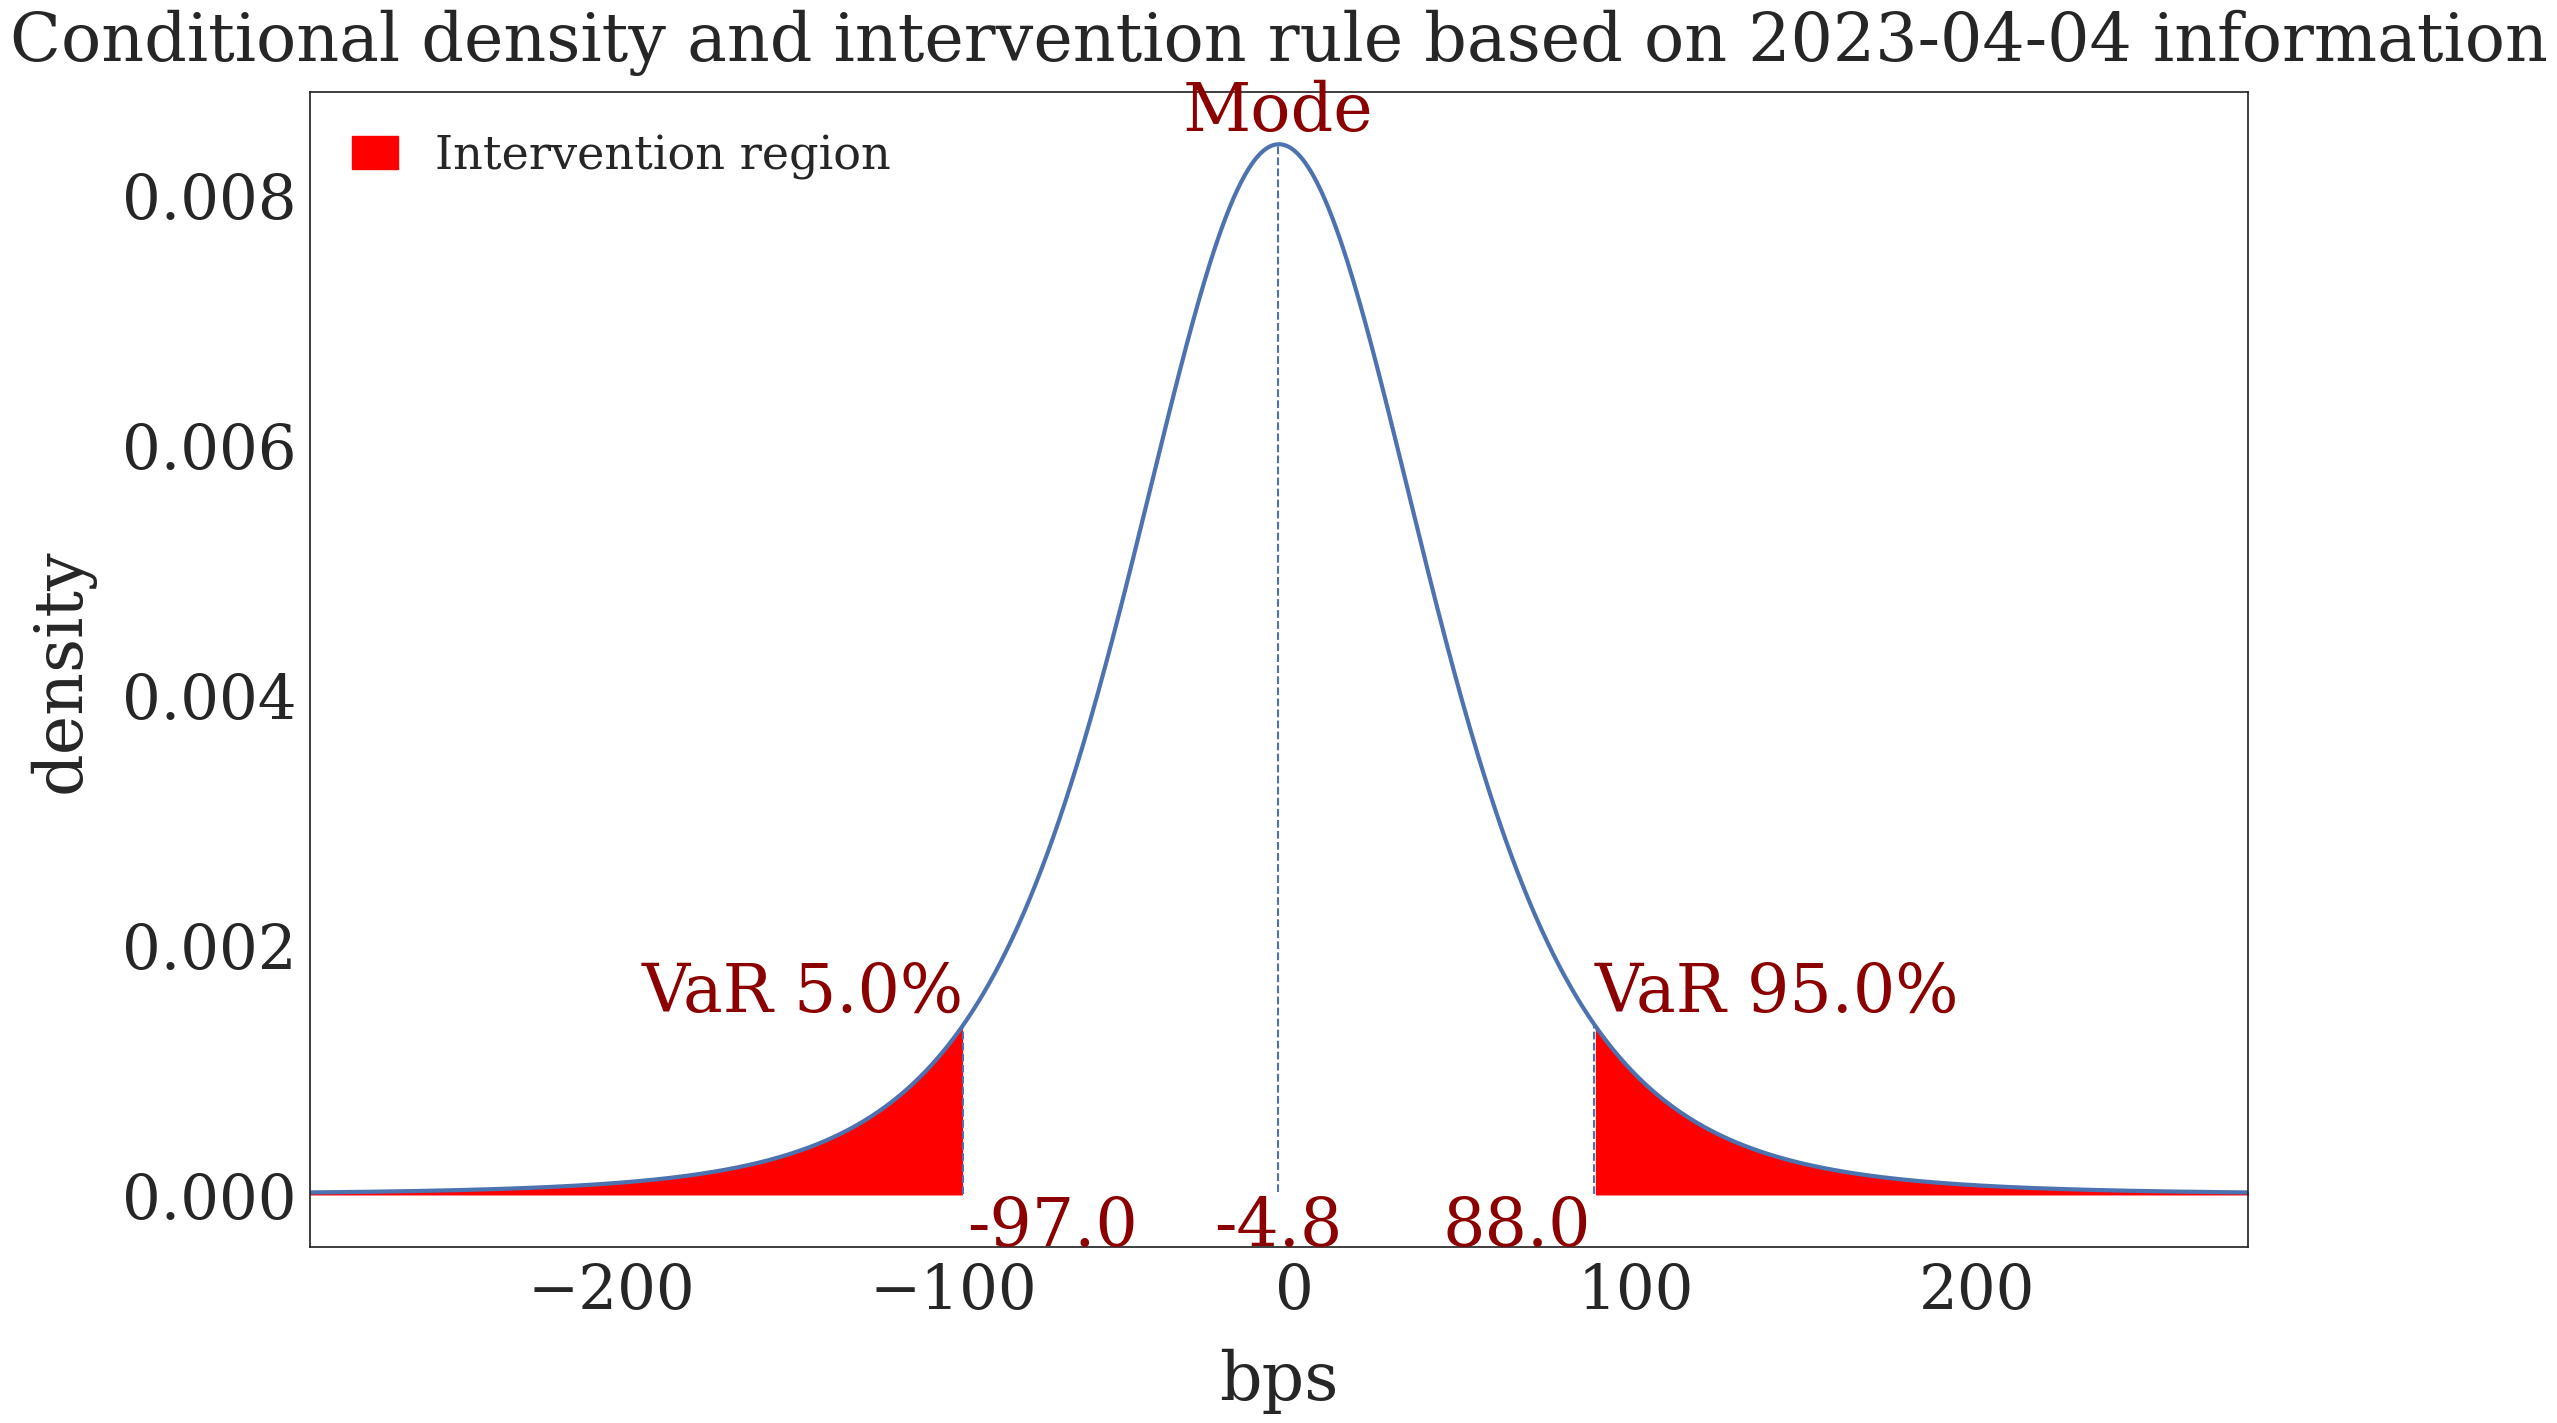

In [60]:
final_forecaster = dgo.final_model.forecast()
final_forecaster.plot.plot_pdf_rule()